# Metabolomic Analysis of Enamel (PH Chromatography, Negative Ionization Mode)
This notebook uses several packages from CRAN, as well as [Bioconductor](https://bioconductor.org). For a full list of attached packages see the session info in the Appendix at the end of this notebook. Several options have been adjusted to improve appearance of plots.

## Quality Control of Raw Data

In [1]:
## Load necessary packages
suppressMessages({
    
    library("xcms")
    library("CAMERA")
    library("RColorBrewer")
    library("SummarizedExperiment")
    library("tidyverse")
    library("gplots")
    library("Rtsne")
    library("caret")
    library("MASS")
    library("ggrepel")
    library("writexl")
    library("matrixStats")
    library("devtools")
    library("ggpubr")
    
    
})

## Set session-specific options
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 120, scipen = -1)

## Define %notin% operator
`%notin%` <- Negate(`%in%`)

Warning message in fun(libname, pkgname):
“mzR has been built against a different Rcpp version (1.0.9)
than is installed on your system (1.0.14). This might lead to errors
when loading mzR. If you encounter such issues, please send a report,
including the output of sessionInfo() to the Bioc support forum at 
https://support.bioconductor.org/. For details see also
https://github.com/sneumann/mzR/wiki/mzR-Rcpp-compiler-linker-issue.”


In [2]:
## List mzXML files
mzXMLs <- list.files(path = "PH_neg", recursive = TRUE, 
                    full.names = TRUE, pattern = ".mzXML")

## Aggregate meta data
sample.name <- sub(basename(mzXMLs), pattern = ".mzXML", 
                   replacement = "", fixed = TRUE)
sample.group <- c(rep("Enamel_acid", 5),rep("Enamel_pellicle_acid", 5),rep("Enamel_pellicle", 5),rep("Enamel", 5),rep("QC", 9))

analysis.order <- c(19,15,6,21,14,24,12,18,9,8,20,22,25,10,28,7,27,16,26,13, 1, 2, 3, 4, 5,11,17,23,29)
analysis.batch <- NA
meta <- data.frame(sample_name = sample.name, 
                   sample_group = sample.group,
                   analysis_order = analysis.order, 
                   analysis_batch = analysis.batch, 
                   stringsAsFactors = FALSE)

In [3]:
## Read raw data from disk
raw <- readMSData(files = mzXMLs[order(analysis.order)], 
                  pdata = new("AnnotatedDataFrame", 
                              meta[order(analysis.order),]), 
                  mode = "onDisk")

## Inspection of Internal Standards
This experiment used the following stable isotope labeled standards to normalise variability introduced by injection of the samples into the mass spectrometer:
- N-methyl-creatinine-d3, \[M+H\]: *m/z* 117.0850
- L-arginine (13C6), \[M+H\]: *m/z* 181.1391, \[M-H\]: *m/z* 179.1245
- L-phenylalanin-d2, \[M-H\]: *m/z* 168.0988, \[M-H\]: *m/z* 166.0843
- Crea, \[M+H\]: *m/z* 114.0662


Quality control at this stage includes ensuring that the internal standards have been detected properly and the within group variability is acceptable.

In [5]:
## Define colours for experimental groups
group.colours <- paste0(brewer.pal(5, "Set1")[1:5])
names(group.colours) <- c("Enamel_acid","Enamel_pellicle_acid","Enamel_pellicle","Enamel", "QC")

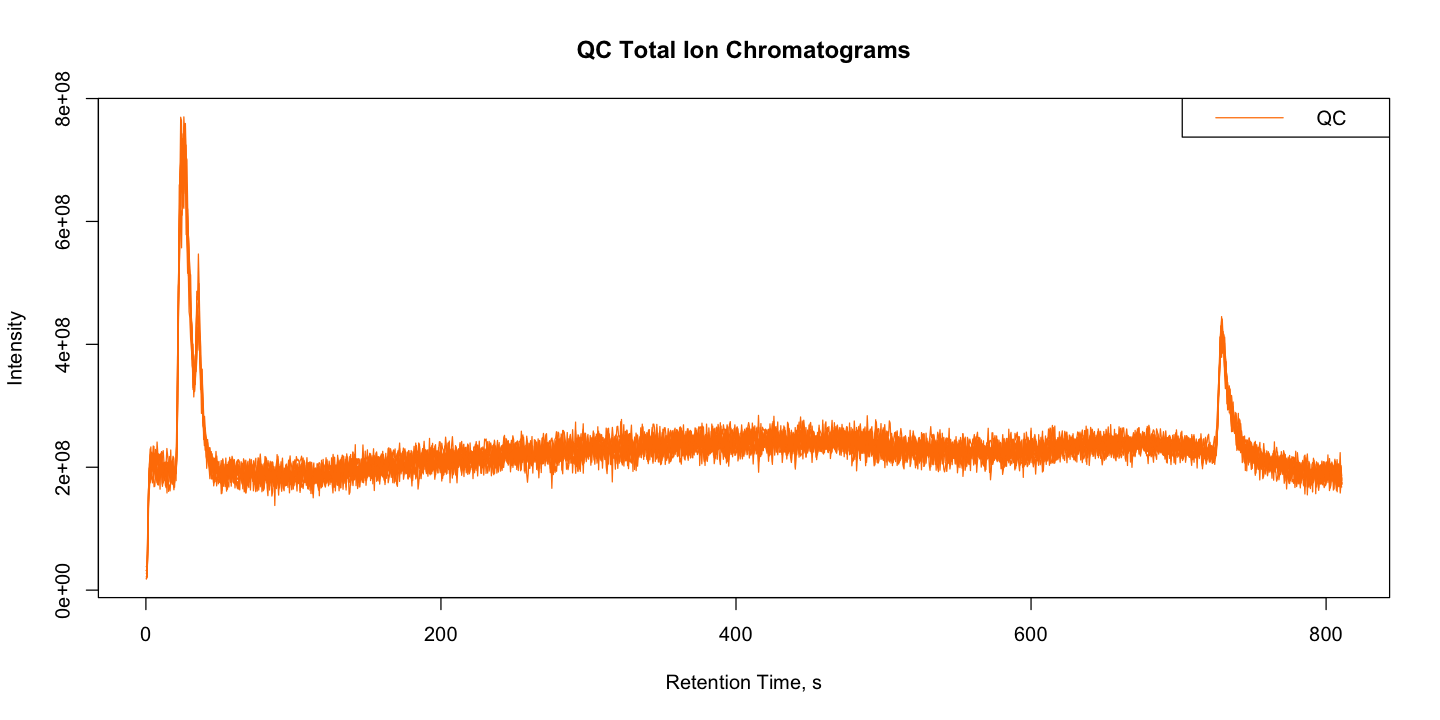

In [6]:
## Get TIC chromatograms
chroms <- chromatogram(raw)

## Plot every QC chromatogram of the data set
plot(chroms[,chroms$sample_group == "QC"], col = group.colours[chroms$sample_group],
     main = "QC Total Ion Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = "QC", 
       col = group.colours[names(group.colours) == "QC"], lty = 1)

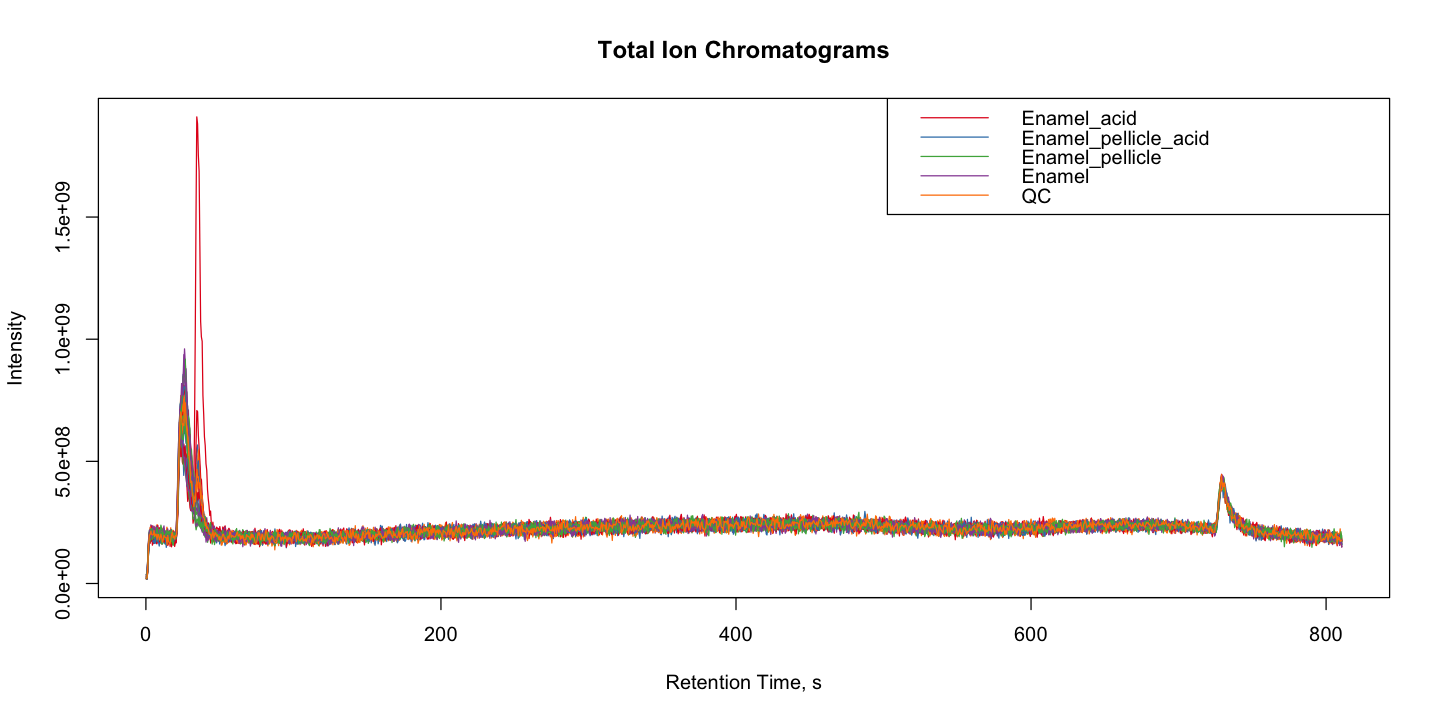

In [7]:
## Plot every chromatogram of the data set
plot(chroms, col = group.colours[chroms$sample_group],
     main = "Total Ion Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

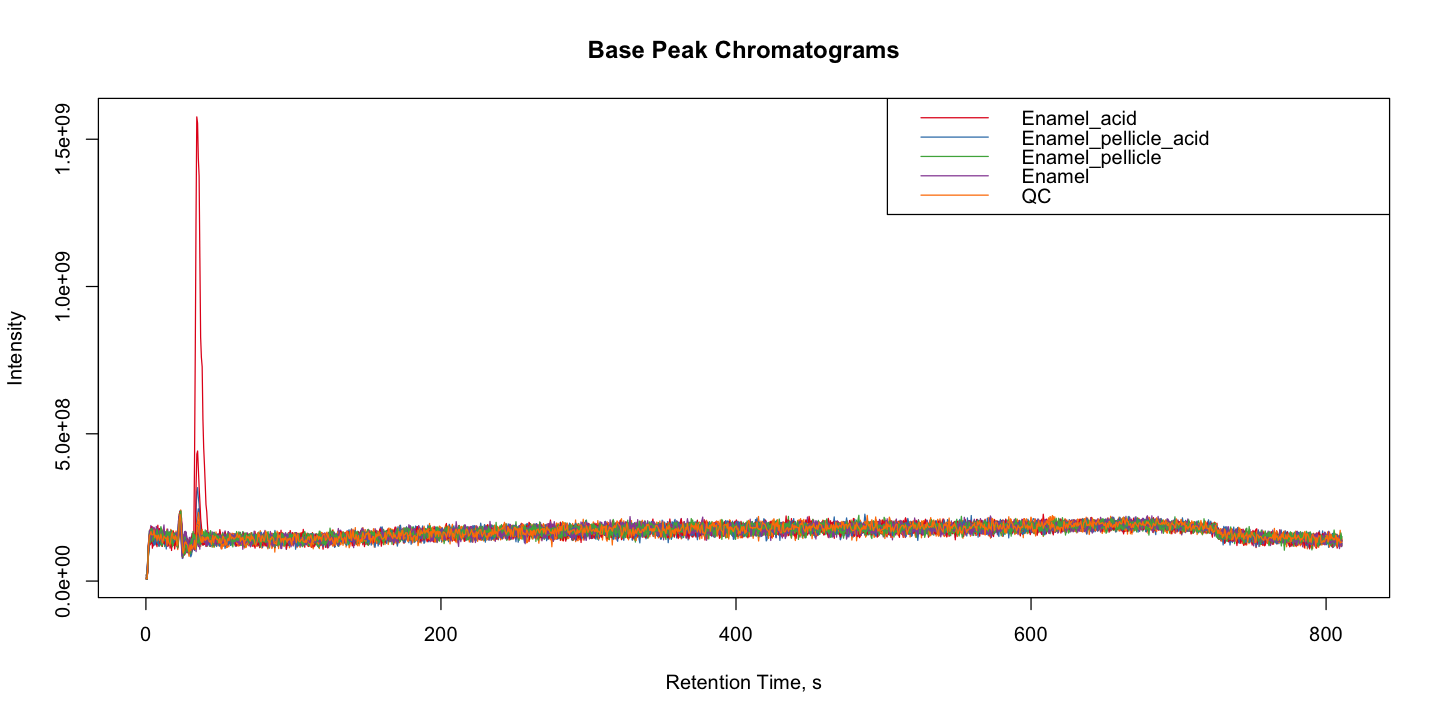

In [8]:
## Get base peak chromatograms
bps <- chromatogram(raw, aggregationFun = "max")

## Plot every base peak chromatogram of the data set
plot(bps, col = group.colours[raw$sample_group], 
     main = "Base Peak Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

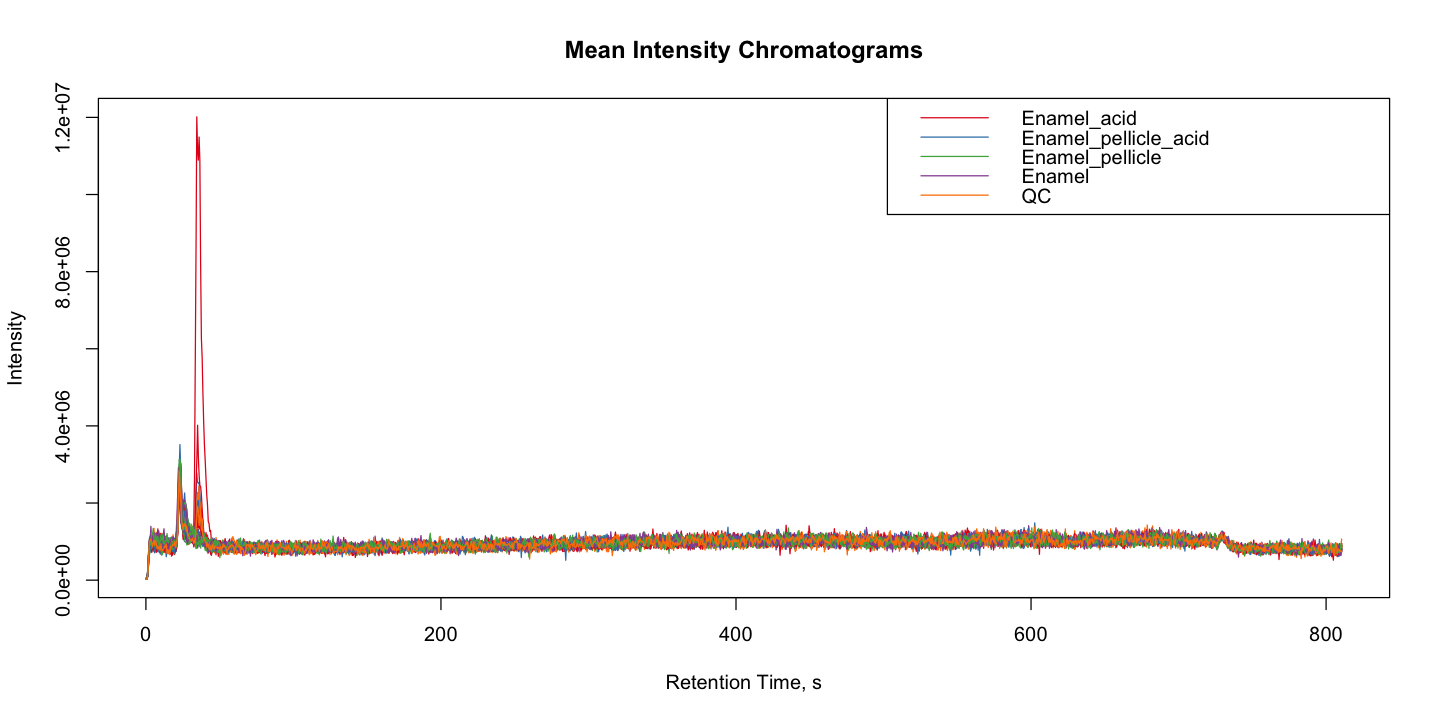

In [9]:
## Get mean intensity chromatograms
means <- chromatogram(raw, aggregationFun = "mean")

## Plot every mean intensity chromatogram of the data set
plot(means, col = group.colours[raw$sample_group], 
     main = "Mean Intensity Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

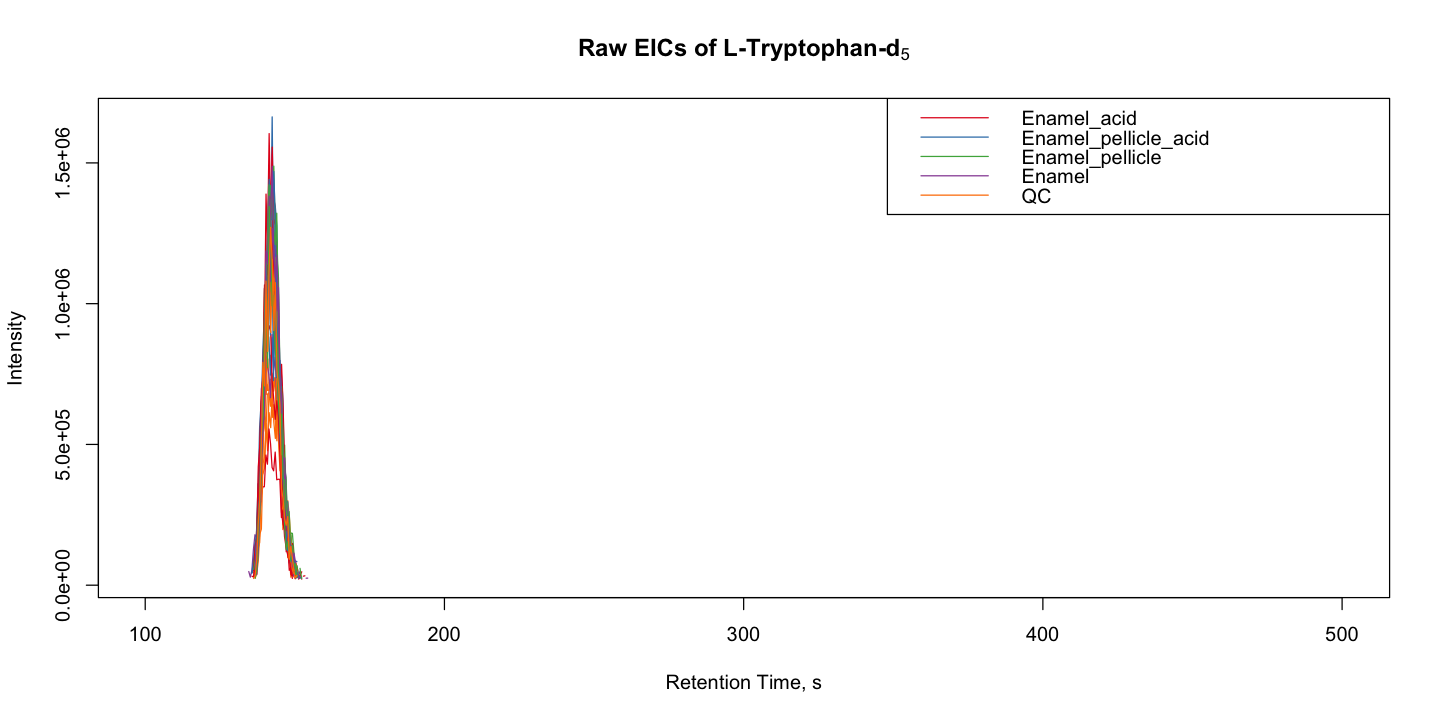

In [11]:
## Plot tryptophan-d5 before processing
Trpd5.raw <- chromatogram(raw, mz = c(208.1130, 208.1150), rt = c(100, 500))

plot(Trpd5.raw, col = group.colours[Trpd5.raw$sample_group], 
     main = bquote(bold("Raw EICs of L-Tryptophan-d"[5])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

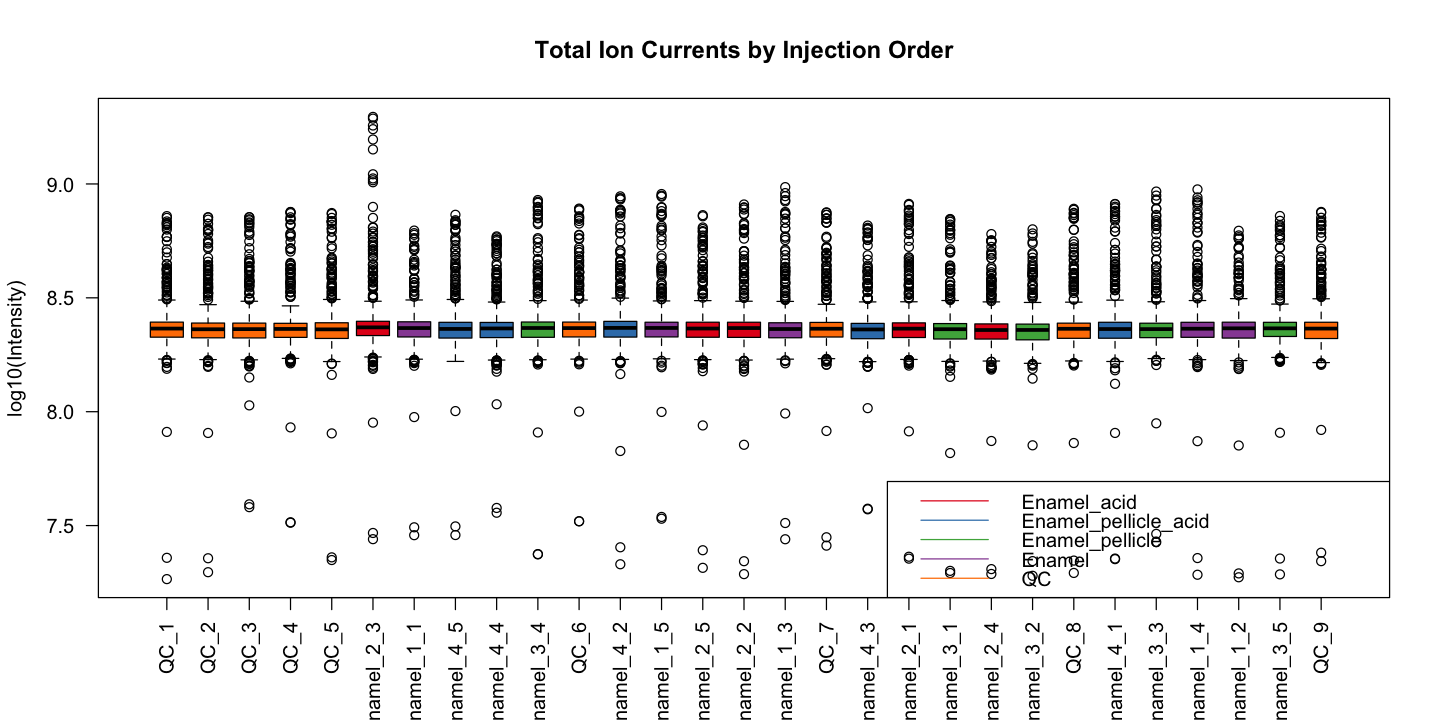

In [14]:
# Inspect boxplots of TICs by injection order
tics.summary <- split(tic(raw), f = fromFile(raw))

boxplot(sapply(tics.summary, log10), names = raw$sample_name, 
        col = group.colours[raw$sample_group], ylab = "log10(Intensity)", 
        main = "Total Ion Currents by Injection Order", las = 2)
legend("bottomright", legend = names(group.colours), 
       col = group.colours, lty = 1)

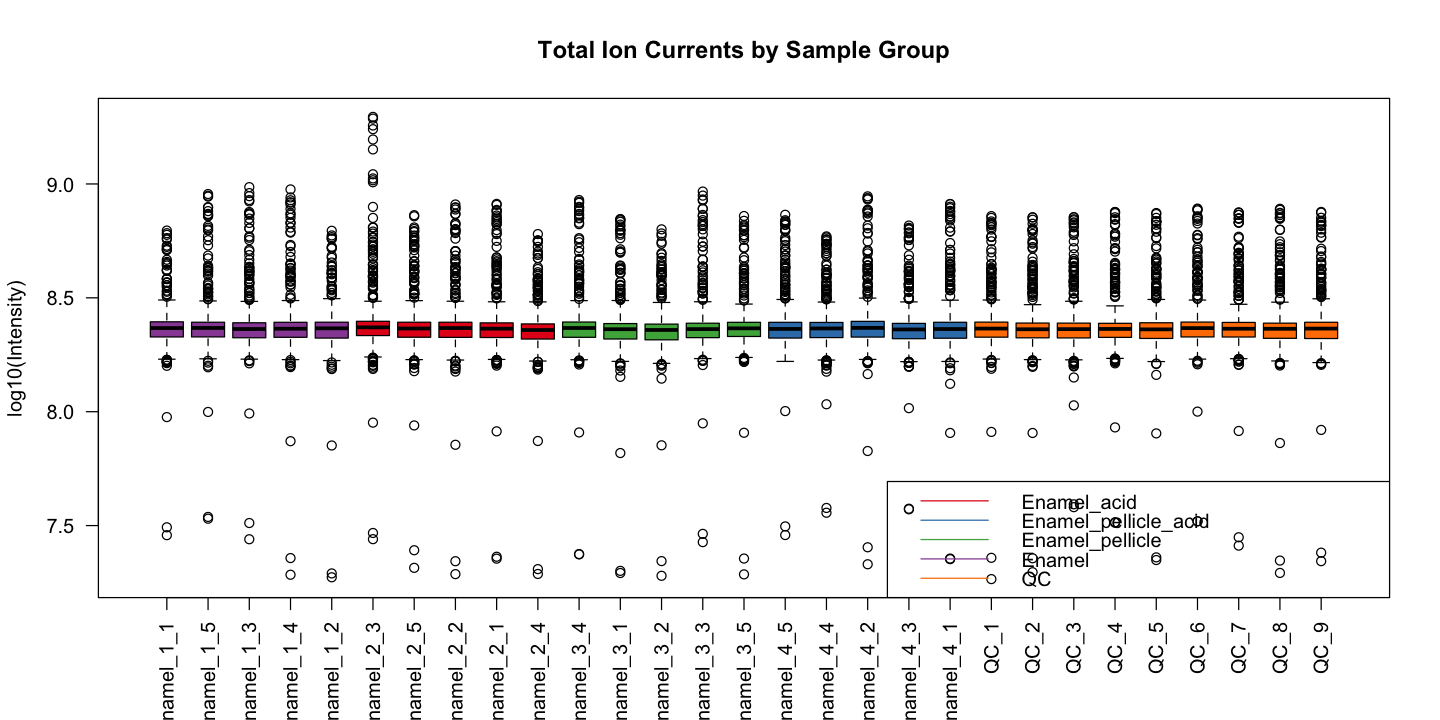

In [15]:
# Inspect boxplots of TICs by sample group
boxplot(sapply(tics.summary, log10)[,order(raw$sample_group)], 
        names = raw$sample_name[order(raw$sample_group)], 
        col = (group.colours[raw$sample_group])[order(raw$sample_group)], 
        ylab = "log10(Intensity)", 
        main = "Total Ion Currents by Sample Group", las = 2)
legend("bottomright", legend = names(group.colours), col = group.colours, lty = 1)

## Preprocessing of Raw Sample Files

### Peak Picking
Parameter used in this section were obtained using the one-by-one optimization performed by [centWaveOpt](https://github.com/saskema/centWaveOpt). This approach was published at [DOI: 10.1002/dta.2552](https://doi.org/10.1002/dta.2552) by Manier et al.

In [16]:
cwp <- CentWaveParam(peakwidth = c(8.9, 100), ppm = 1.9, snthresh = 8, 
                     mzdiff = 0.1,  prefilter = c(7, 100))

suppressMessages(
    
    set <- findChromPeaks(raw, param = cwp)
    
    )

In [17]:
## Define sample colours
sample.colours <- paste0(brewer.pal(5, "Set1")[1:5])
names(sample.colours) <- c("Enamel_acid","Enamel_pellicle_acid","Enamel_pellicle","Enamel", "QC")
sample.colours <- sample.colours[raw$sample_group]

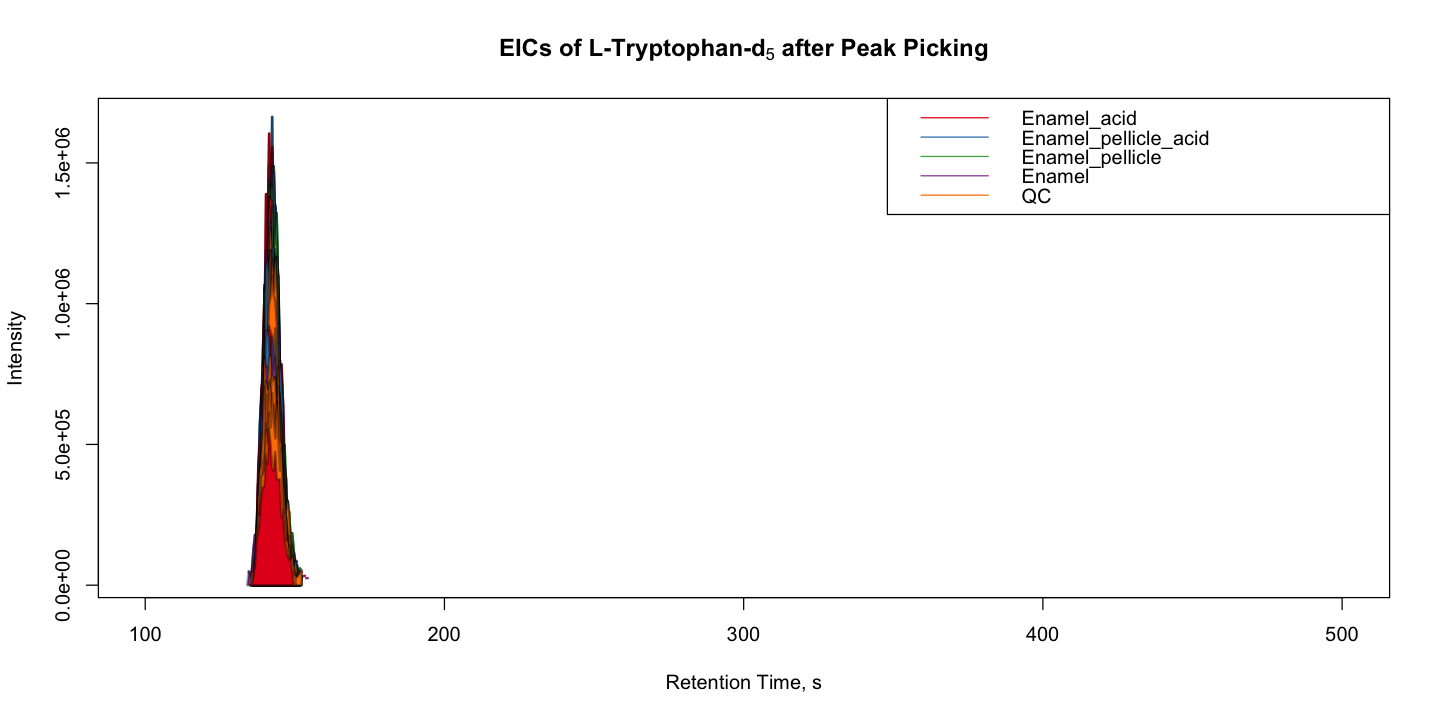

In [19]:
## Plot Tryptophan-d5 after peak picking
Trpd5.picked <- chromatogram(set, mz = c(208.1130, 208.1150), rt = c(100, 500)) 

plot(Trpd5.picked, col = group.colours[Trpd5.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(Trpd5.picked)[, "sample"]],
     main = bquote(bold("EICs of L-Tryptophan-d"[5]*" after Peak Picking")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

### Retention Time Correction (RT)

In [20]:
suppressMessages({
    
    set <- adjustRtime(set, param = ObiwarpParam(binSize = 0.2))
    set <- dropAdjustedRtime(set)

    pdp <- PeakDensityParam(sampleGroups = set$sample_group, bw = 0.3)
    set <- groupChromPeaks(set, param = pdp)

    ## Define subset alignment options and perform the alignment
    pgp <- PeakGroupsParam(minFraction = 0.85, 
                           subset = which(set$sample_group == "QC"),
                           subsetAdjust = "average", span = 0.4)
    set <- adjustRtime(set, param = pgp)
    
})

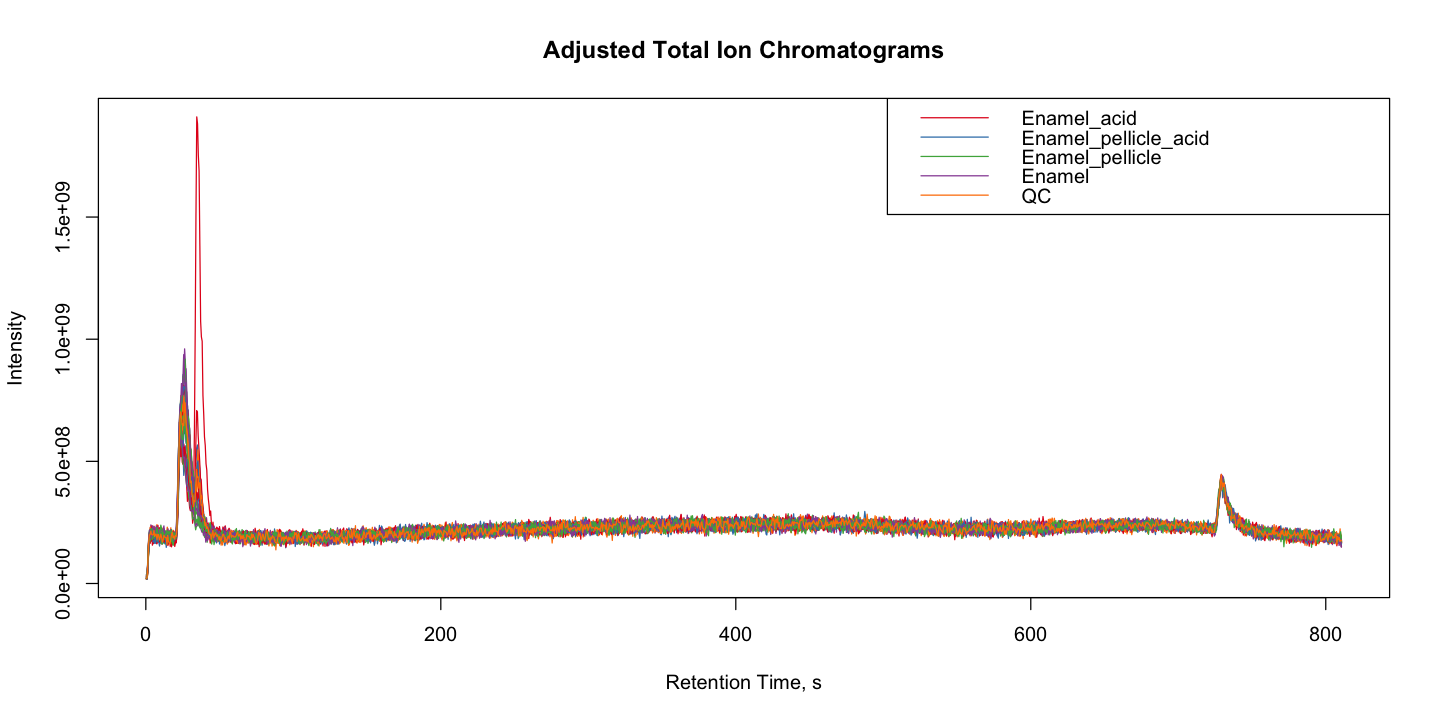

In [21]:
## Get the retention time-adjusted total ion chromatograms.
tics.corr <- chromatogram(set, aggregationFun = "sum")

plot(tics.corr, col = group.colours[tics.corr$sample_group], 
     peakType = "none", main = "Adjusted Total Ion Chromatograms", 
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), col = group.colours, lty = 1)

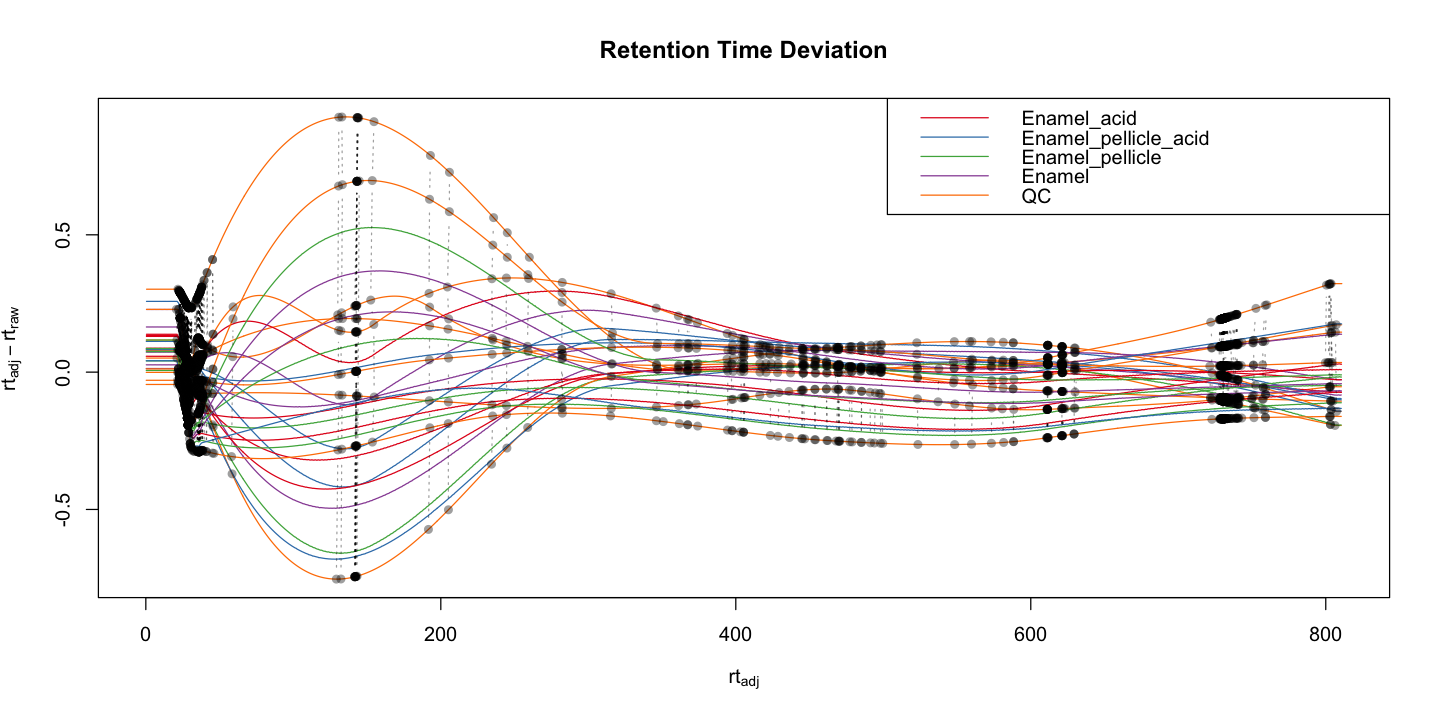

In [22]:
## Plot difference of adjusted to raw retention time.
plotAdjustedRtime(set, col = group.colours[set$sample_group], 
                  main = "Retention Time Deviation")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

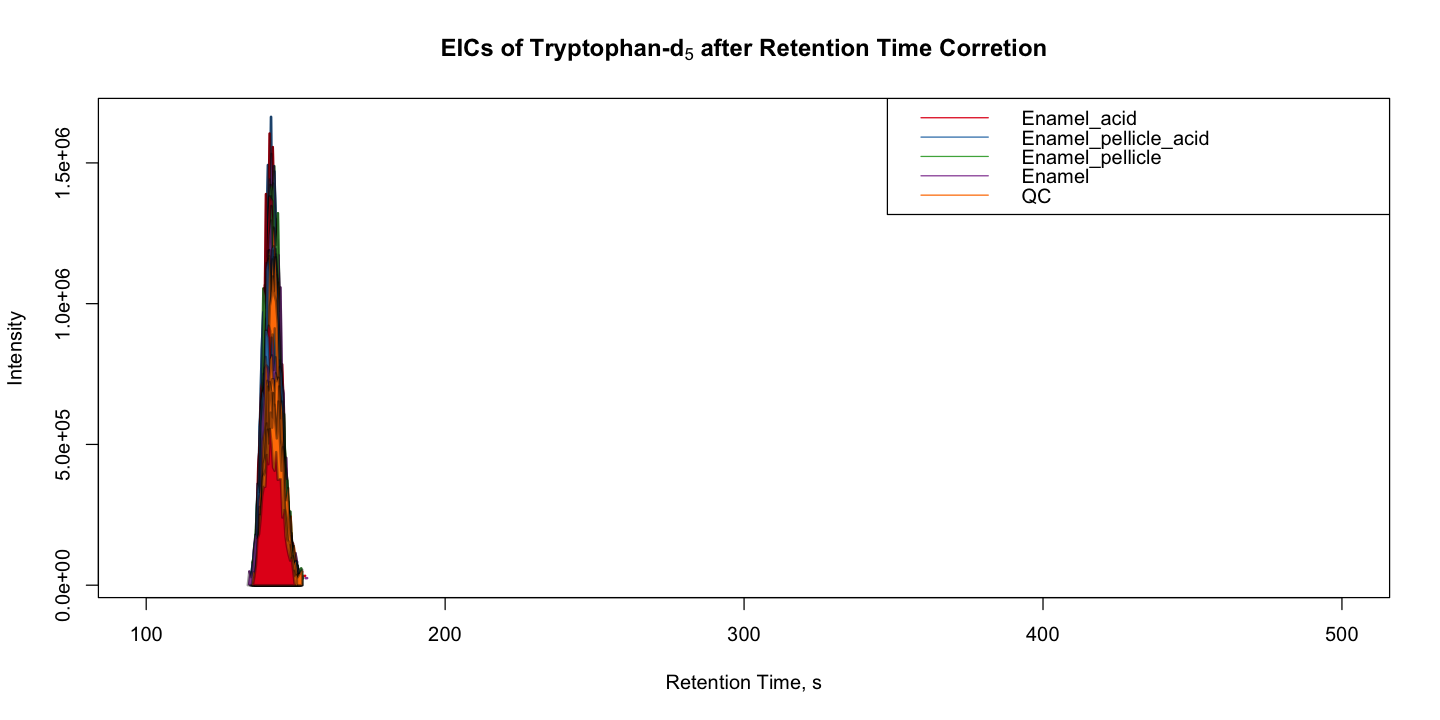

In [24]:
## Plot tryptophan-d5 after retention time correction
Trpd5.corr <- chromatogram(set, mz = c(208.1130, 208.1150), rt = c(100, 500)) 

plot(Trpd5.corr, col = group.colours[Trpd5.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(Trpd5.corr)[, "sample"]],
     main = bquote(bold("EICs of Tryptophan-d"[5]*" after Retention Time Corretion")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

### Peak Grouping

In [25]:
suppressMessages(
    
    set <- groupChromPeaks(set, param = pdp)
    
)

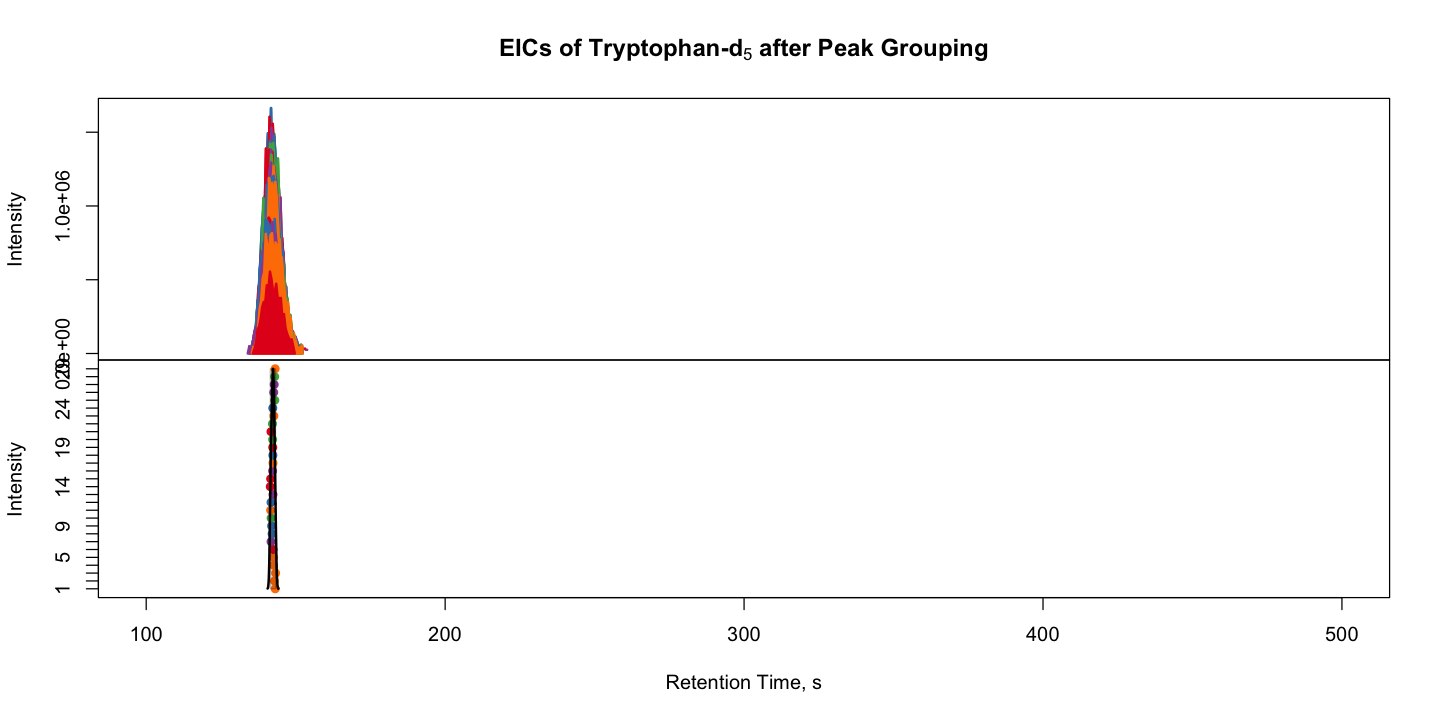

In [27]:
## Plot tryptophan-d5 after peak grouping
Trpd5.grouped <- chromatogram(set, mz = c(208.1130, 208.1150), rt = c(100, 500))

## Define the parameters for the peak density method
plotChromPeakDensity(Trpd5.grouped, col = sample.colours, param = pdp, lwd = 2,
                     peakBg = sample.colours[chromPeaks(Trpd5.grouped)[, "sample"]],
                     peakCol = sample.colours[chromPeaks(Trpd5.grouped)[, "sample"]],
                     peakPch = 16, main = bquote(bold("EICs of Tryptophan-d"[5]*" after Peak Grouping")),
                     xlab = "Retention Time, s", ylab = "Intensity")

### Peak Filling

In [28]:
suppressMessages(    
     
    set <- fillChromPeaks(set, param = ChromPeakAreaParam())
    
)

## Post Processing

### Export Results to SummarizedExperiment-Object

In [29]:
## Summarise experiment
results <- quantify(set, value = "into")

In [30]:
## Add classic feature names
rowData(results)$label <- paste0("M",round(rowData(results)$mzmed,0),
                           "T", round(rowData(results)$rtmed,0))

### Annotation of Adducts and Isotopes

In [31]:
## Perform annotation using CAMERA
suppressMessages({
    
    camera <- set %>%
              as("xcmsSet") %>%
              CAMERA::annotate(polarity  = "negative") %>%
              getPeaklist() %>%
              dplyr::select(isotopes, adduct, pcgroup)
    
})

## Save annotation results in SummarizedExperiment class
rowData(results)$isotopes <- camera$isotopes
rowData(results)$adduct <- camera$adduct
rowData(results)$pcgroup <- camera$pcgroup

Start grouping after retention time.
Created 49 pseudospectra.
Generating peak matrix!
Run isotope peak annotation
 % finished: 50  60  70  80  90  100  
Found isotopes: 81 
Start grouping after correlation.
Generating EIC's .. 

Calculating peak correlations in 49 Groups... 
 % finished: 50  60  70  80  90  100  

Calculating graph cross linking in 49 Groups... 
 % finished: 50  60  70  80  90  100  
New number of ps-groups:  176 
xsAnnotate has now 176 groups, instead of 49 
Generating peak matrix for peak annotation!

Calculating possible adducts in 176 Groups... 
 % finished: 40  50  60  70  80  90  100  


### Scaling
Before log10 transformation, every NA in the data matrix is replaced by the surrogate LOD according to Wehrens et al. at [DOI: 10.1007/s11306-016-1015-8](https://doi.org/10.1007/s11306-016-1015-8). The surrogate LOD is the lowest area that was measured during the analysis.

In [32]:
# Replacing NAs with surrogate LOD
lod <- assay(results, "raw")[is.na(assay(results, "raw")) == FALSE] %>%
       min()
assay(results, "raw")[is.na(assay(results, "raw"))] <- lod

In [33]:
# Create separate (scaled) assay results within same object
assay(results, "scaled") <- assay(results, "raw") %>%
                            log10()

# Normalisation

In [34]:
## Define function to calculate ppm deviation
ppm <- function(x,y) {

    return(10^6 * (x - y) / y)

}

## Define function to identify row of compound
identify <- function(data, mz, rt, ppmlim, rtlim) {

    delta.mz <- abs(mapply(ppm, x = data$mzmed, y = mz))
    delta.rt <- abs(data$rtmed - rt)
    return(which(delta.mz < ppmlim & delta.rt < rtlim))
    
}

### Batch correction

In [35]:
## Define function to perform batch correction
batchCorrection <-function(area, order, group, output = c("df", "corr")) {
        
    df <- data.frame(order = order, area = area)
    model <- lm(area ~ order, data = df[group == "QC",])
    df$pred <- predict(model, newdata = df)
    df$corr <- df$corr <- df$area - df$pred + mean (df$area)
    return(switch(output, df = df, corr = df$corr))
    
}

In [36]:
## Perform batch correction
assay(results, "batchcorr",
      withDimnames = FALSE) <- apply(assay(results, "scaled"), 
                                     1, batchCorrection, 
                                     order = set$analysis_order, 
                                     group = set$sample_group, 
                                     output = "corr") %>%
                                     t()

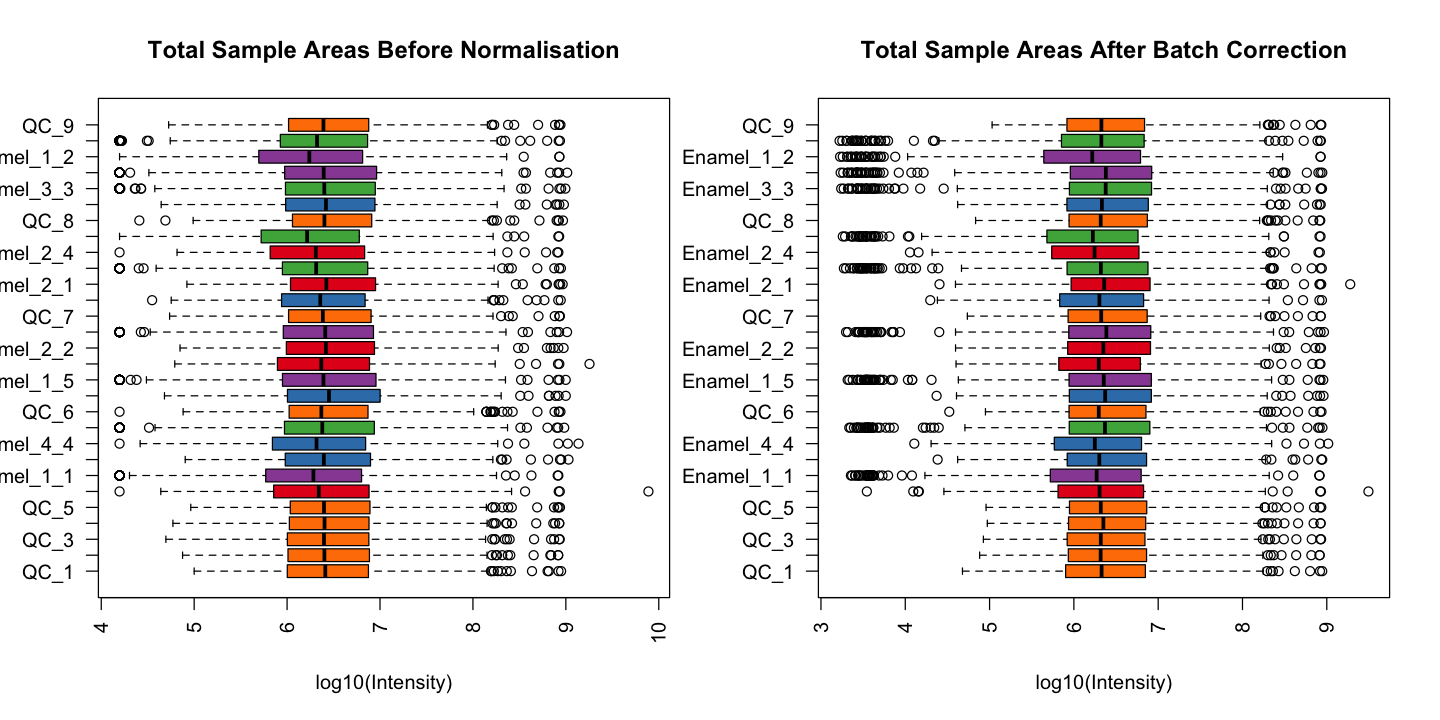

In [37]:
## Compare batch-corrected and uncorrected total sample areas
par(mfrow = c(1,2))

results %>%
assay("scaled") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas Before Normalisation", las = 2)

results %>%
assay("batchcorr") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas After Batch Correction", las = 2)

## Statistical Evaluation

### ANOVA 
Bonferoni Correction mit p-value < 0.05/Anzahl Feature

In [38]:
## Define results column
rowData(results)$pvalue <- NA

## Calculate ANOVA for each feature
anova.table <- results[,results$sample_group != "QC"] %>%
               assay("batchcorr") %>%
               t()
anova.factor <- results$sample_group[results$sample_group != "QC"]

for(i in 1:ncol(anova.table)) {
        
    sum <- aov(anova.table[,i]~anova.factor) %>%
           summary() %>%
           unlist()
    rowData(results)$pvalue[i] <- sum["Pr(>F)1"]
    
    }

## Evaluate p-values
rowData(results)$significant <- ifelse(rowData(results)$pvalue < 0.005,
                                       TRUE, FALSE)

##Bonferoni Correction: 0.05/720 (Anzahl Feature) -> 0.00007

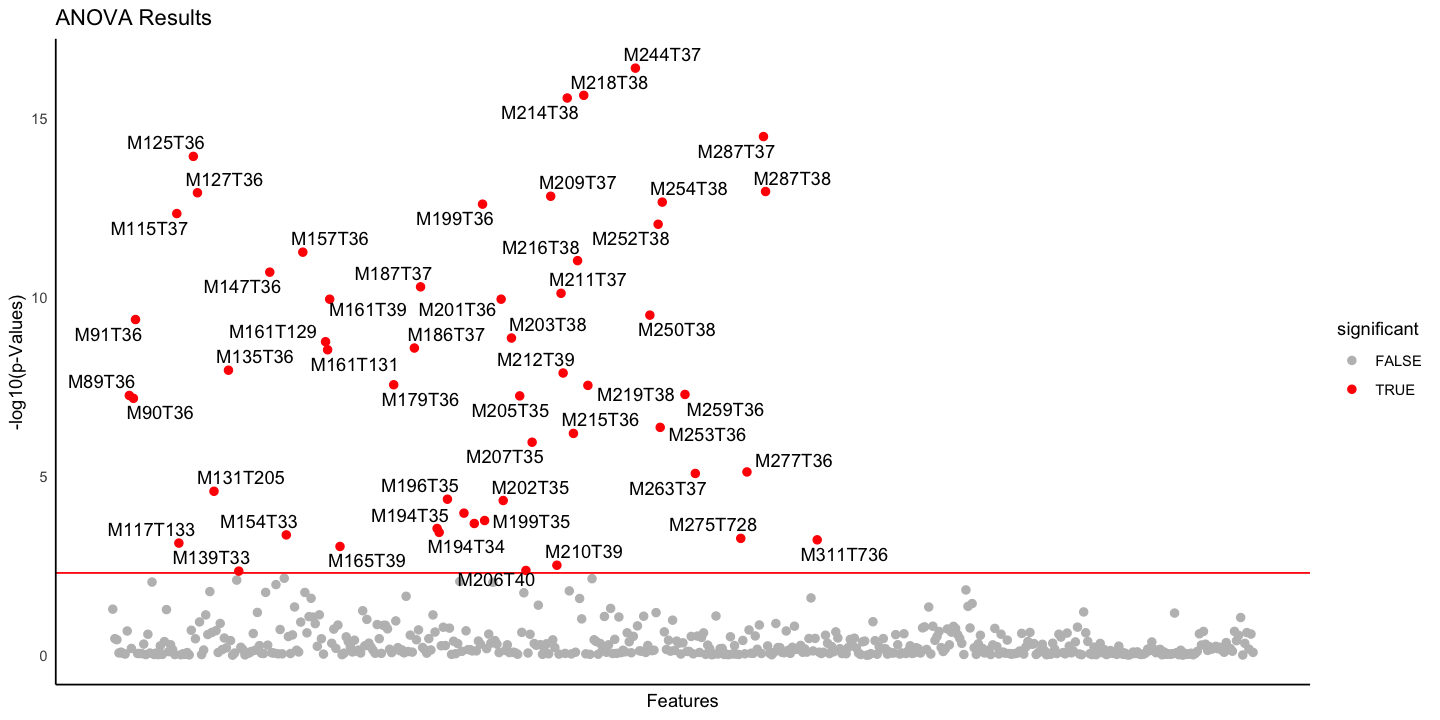

In [39]:
coloursBoolean <- c("TRUE" = "red", "FALSE" = "grey")

results %>%
rowData() %>%
as.data.frame %>%
ggplot(aes(x = 1:nrow(rowData(results)), y = -log10(pvalue),
           label = ifelse(rowData(results)$significant, 
                          rowData(results)$label, ""), colour = significant)) +
geom_point(size = 2) +
scale_color_manual(values = coloursBoolean) +
geom_hline(yintercept = -log10(0.005), colour = "red") +
geom_text_repel(point.padding = 0.2, colour = "black") +
ggtitle("ANOVA Results") +
xlab("Features") +
ylab("-log10(p-Values)") +
theme_classic() +
theme(axis.text.x = element_blank(),
      axis.ticks = element_blank())

### Evaluate Significance

In [40]:
results.filtered <- results[rowData(results)$significant == TRUE,]

### Hierarchical Clustering

In [41]:
## Calculate row and column cluster
r.cluster <- results.filtered %>%
             assay("batchcorr") %>%
             dist(method = "manhattan") %>%
             hclust(method = "complete") %>%
             as.dendrogram()

c.cluster <- results.filtered %>%
             assay("batchcorr") %>%
             t() %>%
             dist(method = "manhattan") %>%
             hclust(method = "complete") %>%
             as.dendrogram()

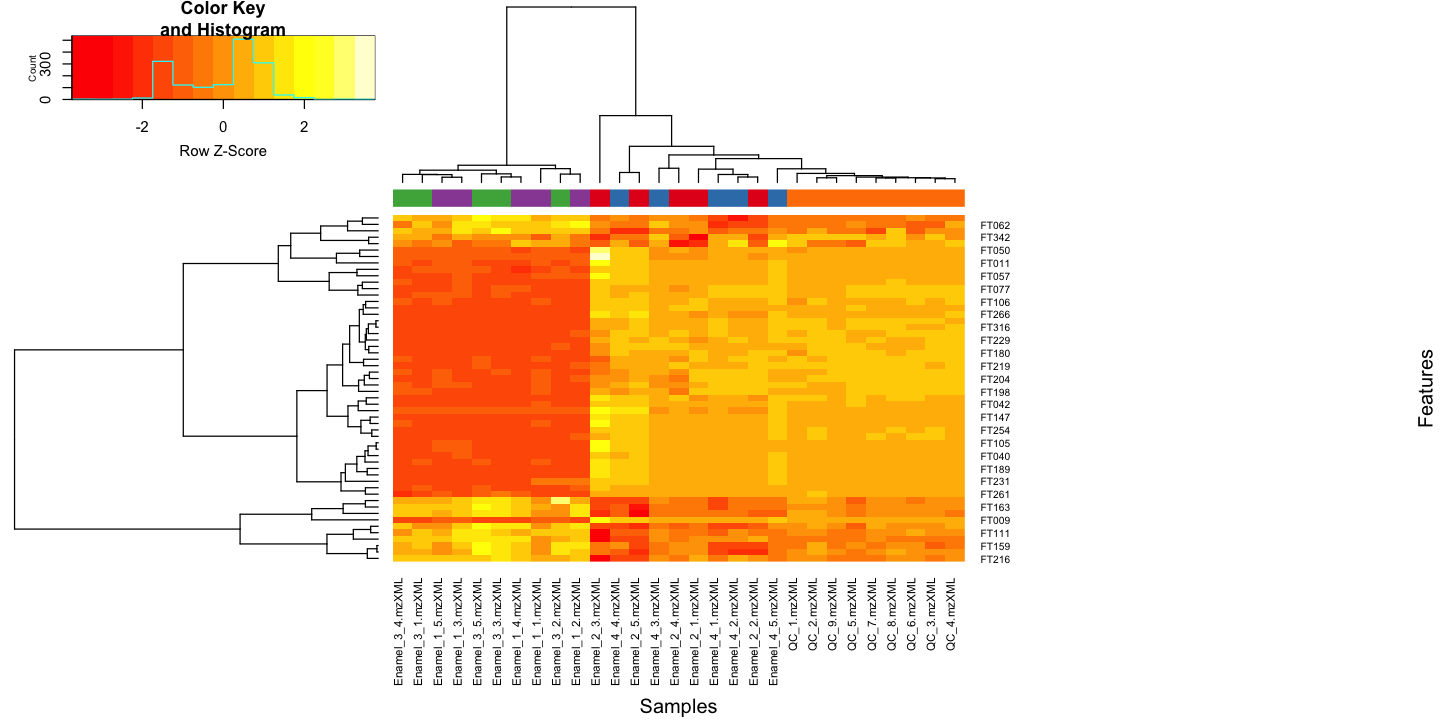

In [42]:
## Plot results of hierarchical clustering
results.filtered %>%
assay("batchcorr") %>%
heatmap.2(scale = "row", margins = c(10,30), trace = "none", 
          Rowv = r.cluster, Colv = c.cluster, ColSideColors = group.colours[results$sample_group],
         xlab = "Samples", ylab = "Features")

### t-SNE

In [43]:
## Perform t-SNE
tsne <- results.filtered %>%
        assay("batchcorr") %>%
        t() %>%
        Rtsne(dim = 2, perplexity = 4, 
              epoch = 100,verbose = FALSE, 
              pca_center = TRUE, pca_scale = FALSE)

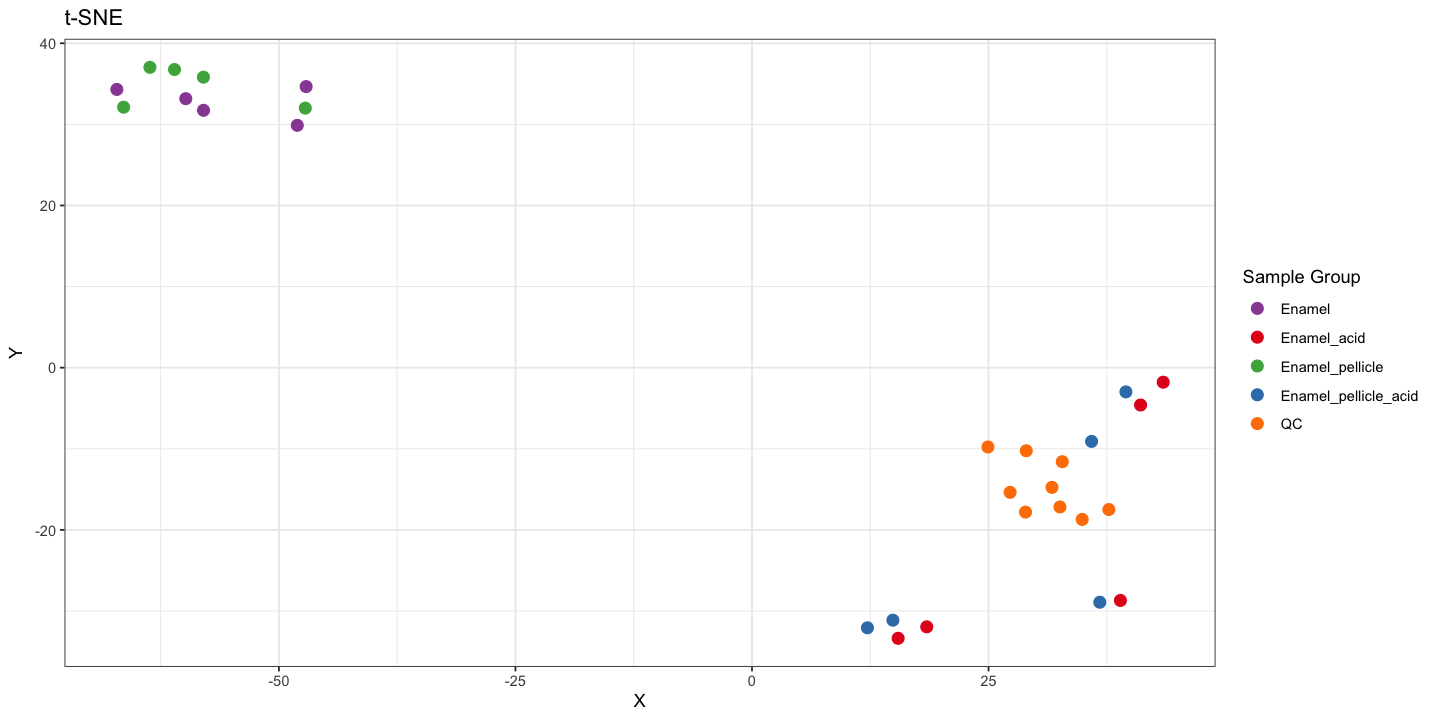

In [44]:
tsne$Y %>%
as.data.frame() %>%
ggplot(aes(x = V1, y = V2, col = results.filtered$sample_group)) +
geom_point(size = 3) +
labs(fill="Sample Group") +
scale_color_manual("Sample Group", values = group.colours) +
#geom_text(aes(label = rownames(pca$x)), vjust = -0.5, hjust = 0.5) +
ggtitle("t-SNE") +
xlab("X") +
ylab("Y") +
theme_bw()

### Principal Component Analysis

In [45]:
## Perform PCA of significant features
pca <- results.filtered %>%
       assay("batchcorr") %>%
       t() %>%
       prcomp(center = TRUE)

## Perform summary of PCA characteristics
pca.summary <- summary(pca)
var <- results.filtered %>%
       assay("batchcorr") %>%
       var()
eig <- pca$sdev^2
kaiser <- length(which(eig > mean(eig)))
jolliffe <- length(which(eig > (0.7*mean(eig))))
scree <- data.frame(PC = seq(from = 1, to = length(eig), by = 1),
                    Eigenvalue = eig/sum(eig))
scree$Importance <- pca.summary$importance[3,]
scree <- reshape(data = scree, direction = "long",
                     varying = c("Eigenvalue", "Importance"),
                     v.names = "Value", idvar = "PC",
                     timevar = "Characteristic",
                     times = c("Eigenvalue", "Importance"))

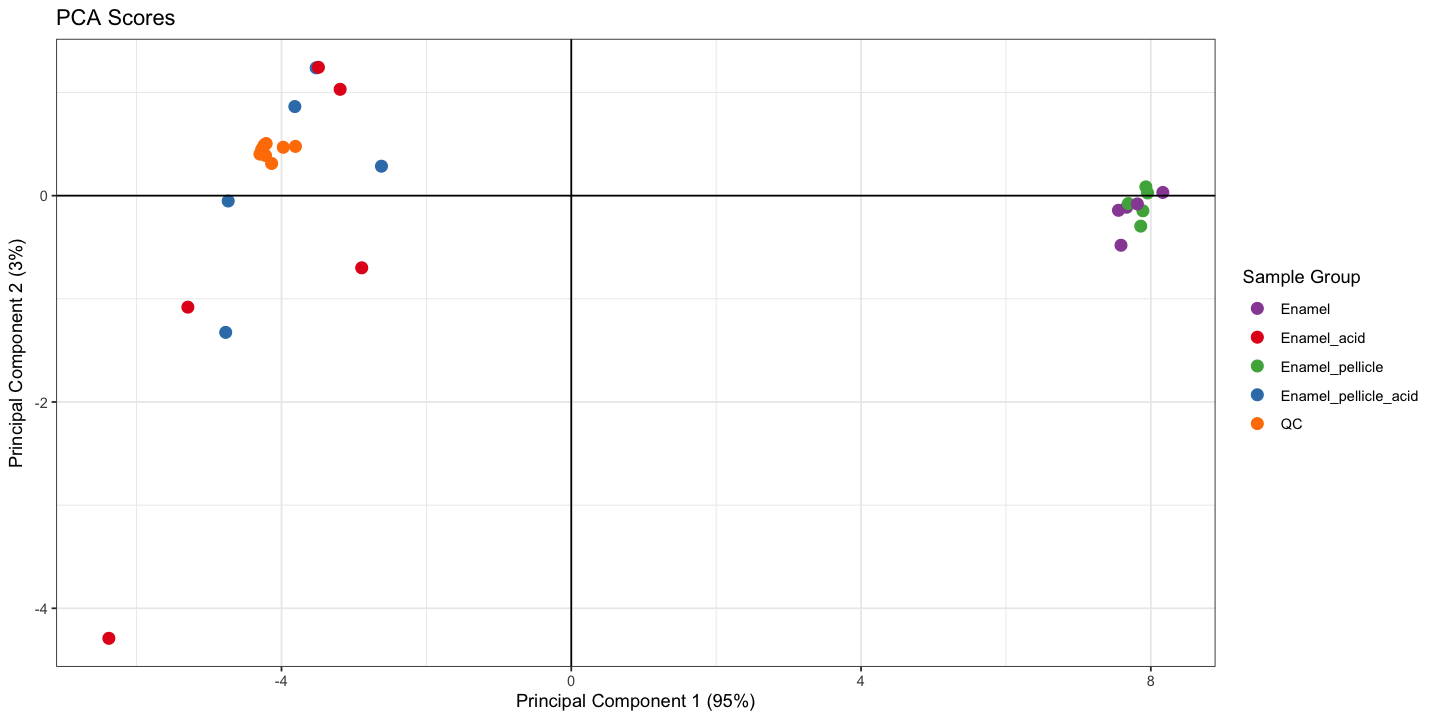

In [46]:
## Plot PCA scores
pca$x %>%
as.data.frame %>%
ggplot(aes(x = PC1, y = PC2)) +
geom_point(size = 3, aes(col = results.filtered$sample_group)) +          
scale_color_manual("Sample Group", values = group.colours) +
geom_hline(yintercept = 0) +
geom_vline(xintercept = 0) +
ggtitle("PCA Scores") +
#geom_text(aes(label = rownames(pca$x)), vjust = -0.5, hjust = 0.5) +
xlab(paste0("Principal Component 1", " ", "(", 
            round(pca.summary$importance[2,1]*100, 0), "%)")) +
ylab(paste0("Principal Component 2", " ", "(", 
            round(pca.summary$importance[2,2]*100, 0), "%)")) +
theme_bw() 

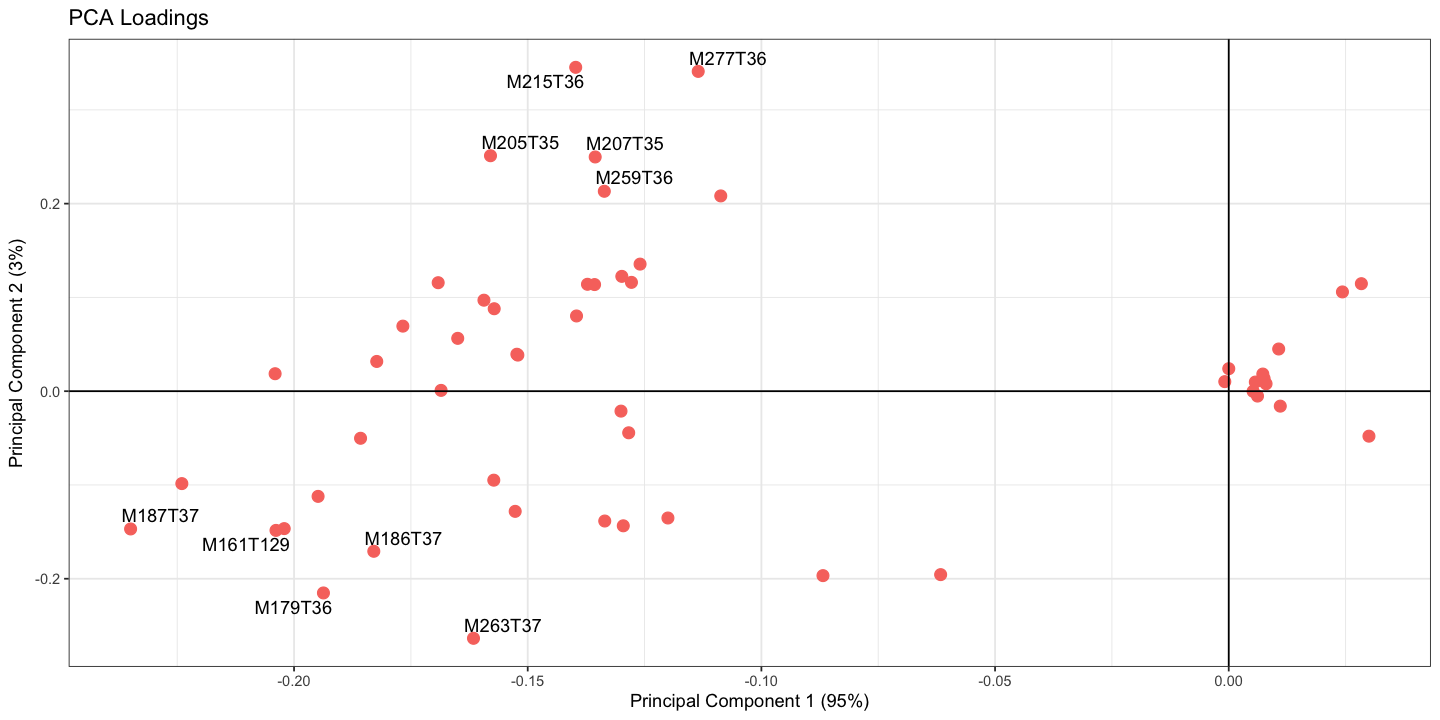

In [47]:
## Plot PCA loadings
pca$rotation %>%
data.frame(label = rowData(results.filtered)$label, 
           abs_loading = sqrt((pca$rotation[,1])^2 + (pca$rotation[,2])^2)) %>%
ggplot(aes(x = PC1, y = PC2,
           label = ifelse(abs_loading >= sort(abs_loading, 
                                              decreasing = TRUE)[10], label, ""))) +
geom_point(size = 3, show.legend = FALSE, aes(col = "red")) +
geom_text_repel(point.padding = 0.2) +
geom_hline(yintercept = 0) +
geom_vline(xintercept = 0) +
ggtitle("PCA Loadings") +
xlab(paste0("Principal Component 1", " ", "(", 
            round(pca.summary$importance[2,1]*100, 0), "%)")) +
ylab(paste0("Principal Component 2", " ", "(", 
            round(pca.summary$importance[2,2]*100, 0), "%)")) +
theme_bw()

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


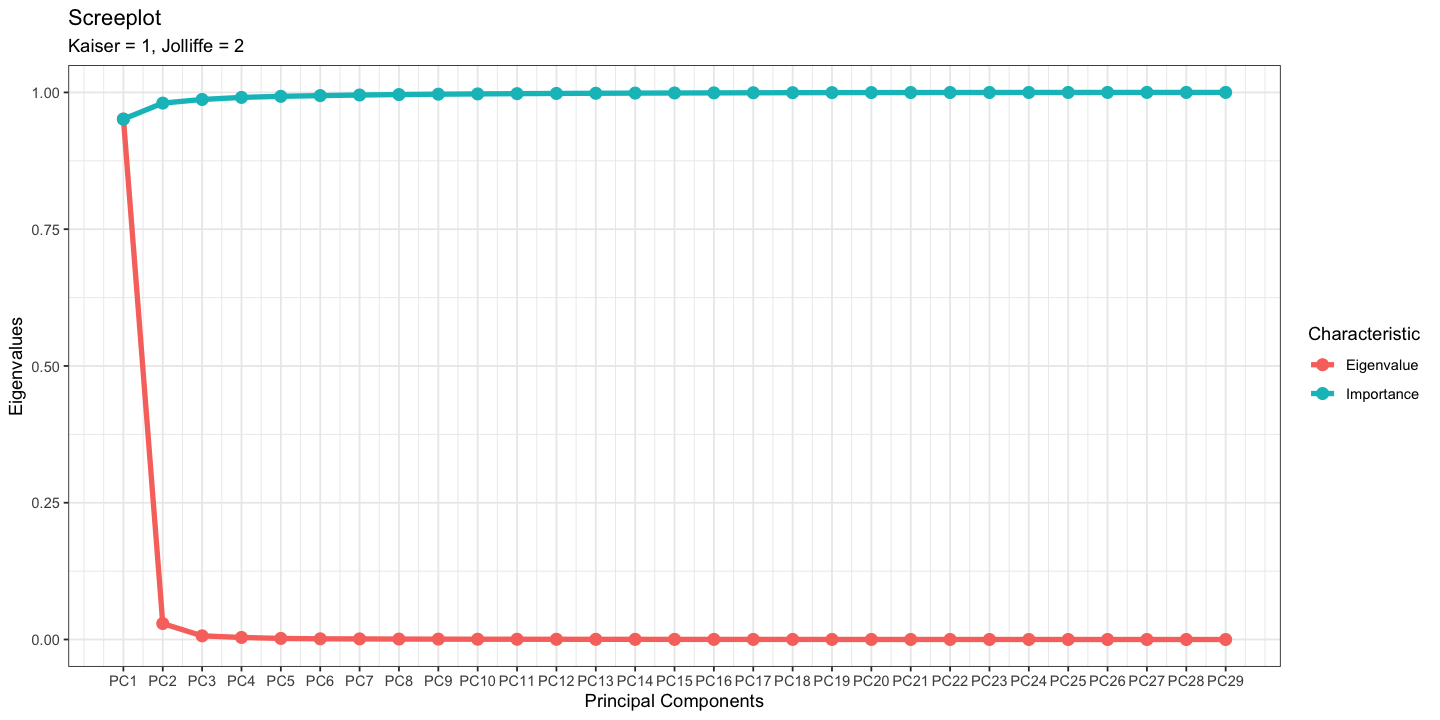

In [48]:
scree %>%
ggplot(aes(x = PC, y = Value, group = Characteristic,
                                     colour = Characteristic)) +        
geom_line(size = 1.5) +
geom_point(size = 3) +
scale_x_continuous(breaks = unique(scree$PC), labels = colnames(pca$rotation)) +
ggtitle(label = "Screeplot",
        subtitle = paste0("Kaiser = ", kaiser, ", Jolliffe = ", jolliffe)) +
xlab("Principal Components") +
ylab("Eigenvalues") +
theme_bw()

### PC-LDA

In [49]:
## Determine number of PCs for LDA
n.pc <- length(which(pca$sdev^2 > mean(pca$sdev^2)))
n.pc <- ifelse(n.pc < 3, 3, n.pc)

## Perform LDA and calculate new loadings
pc.ldam <- pca$x[,1:n.pc] %>%
           as.matrix() %>%
           lda(results$sample_group)

pc.lda.loadings <- pca$rotation[,1:n.pc] %*% pc.ldam$scaling

# Calculate aboslute loading and save to results
rowData(results.filtered)$abs_loading <- sqrt(abs(pc.lda.loadings[,1])^2 + 
                                     abs(pc.lda.loadings[,2])^2)

## Calculate prediction accuracy and cohens kappa
monte.carlo <- train(pca$x[,1:n.pc], results.filtered$sample_group,
                     method = "lda",
                     trControl = trainControl(method = "LGOCV"))
cvaccuracy <- as.numeric(round(monte.carlo$results[2]*100, 0))
cvkappa <- as.numeric(round(monte.carlo$results[3]*100, 0))
    
## Predict model for test data
p <- predict(pc.ldam, as.data.frame(pca$x[,1:n.pc]))

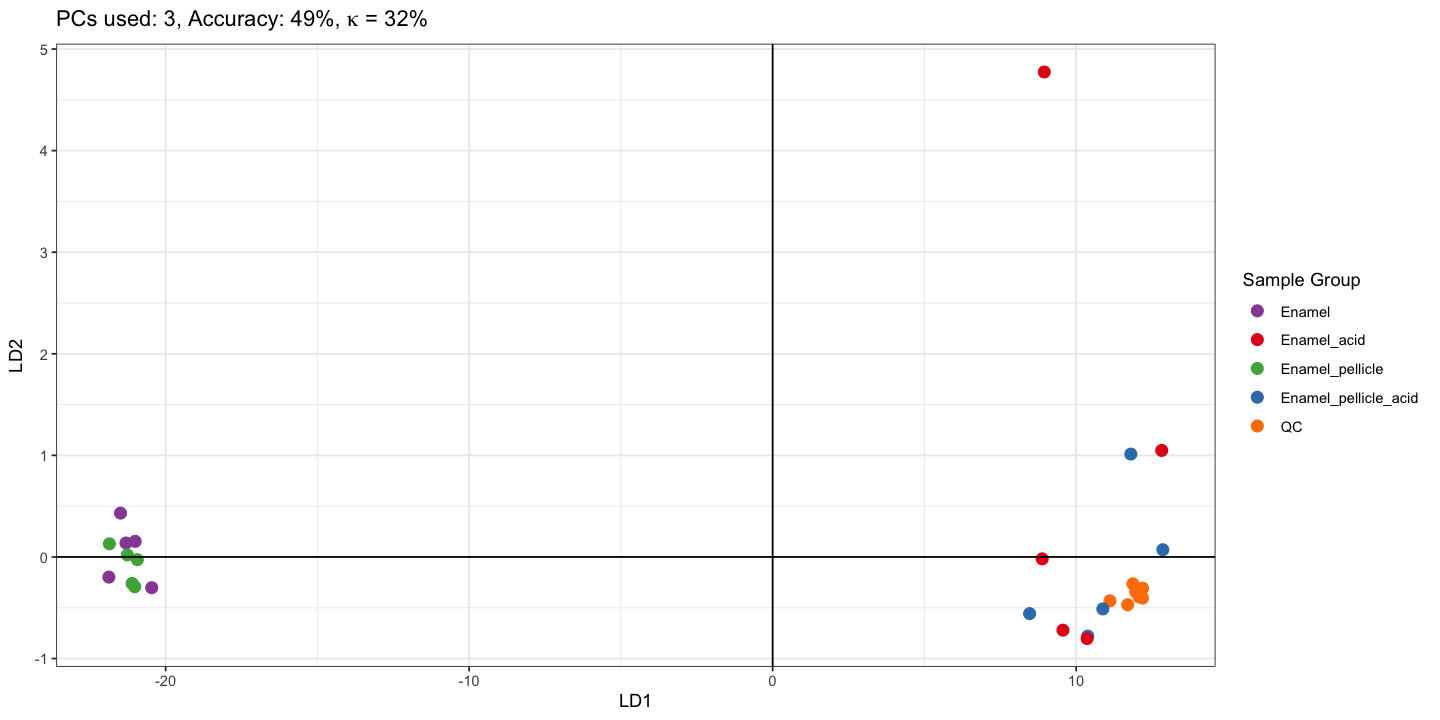

In [50]:
## Plot PC-LDA scores
p$x %>%
as.data.frame() %>%
ggplot(aes(x = LD1, y = LD2)) +
geom_point(size = 3, aes(col = results.filtered$sample_group)) +
scale_color_manual("Sample Group", values = group.colours) +
geom_hline(yintercept = 0) +
geom_vline(xintercept = 0) +
ggtitle(substitute(paste("PCs used: ", n_pc, ", ", "Accuracy: ", 
                         cvacc, "%, ", kappa, " = ", cvka, "%"),
                   list(n_pc = n.pc, cvacc = cvaccuracy, cvka = cvkappa))) +
theme_bw()

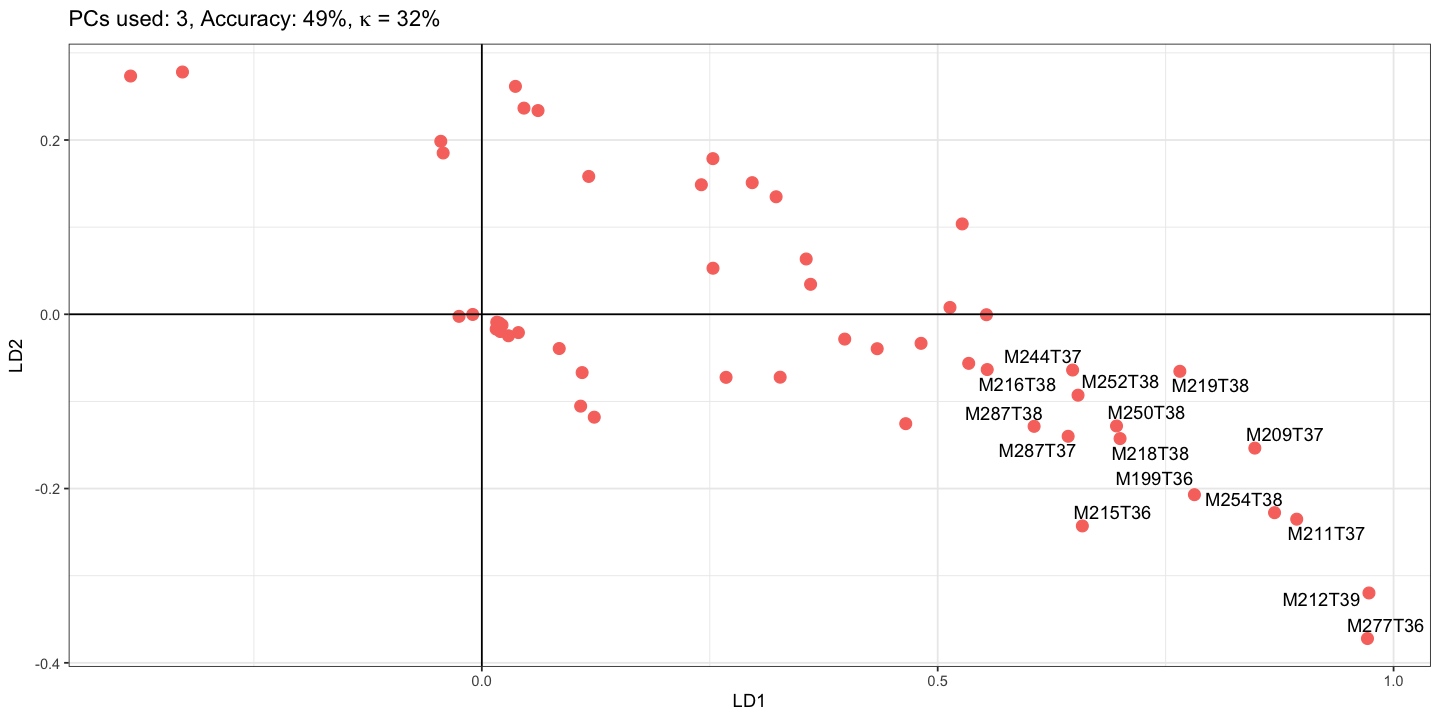

In [51]:
## Plot PCA loadings
pc.lda.loadings %>%
data.frame(label = rowData(results.filtered)$label, 
           abs_loading = rowData(results.filtered)$abs_loading) %>%
ggplot(aes(x = LD1, y = LD2, label = ifelse(abs_loading >= sort(abs_loading, 
                                              decreasing = TRUE)[15], label, ""))) +
geom_point(size = 3, aes(col = "red"), show.legend = FALSE) +
geom_hline(yintercept = 0) +
geom_vline(xintercept = 0) +
geom_text_repel(point.padding = 0.2) +
ggtitle(substitute(paste("PCs used: ", n_pc, ", ", "Accuracy: ", cvacc, "%, ",
                         kappa, " = ", cvka, "%"),
                   list(n_pc = n.pc, cvacc = cvaccuracy, cvka = cvkappa))) +
theme_bw()

## Summarise significant features to a table

In [56]:
summary <- results.filtered %>%
           rowData() %>%
           as.data.frame() %>%
           filter(significant == TRUE) %>%
           dplyr::select(label, mzmed, rtmed, pvalue, abs_loading,
                         isotopes, adduct, pcgroup) %>%
           arrange(desc(abs_loading))
summary[1:55,]

label    mzmed     rtmed     pvalue       abs_loading isotopes  
FT308 M277T36  276.94060  36.49260 7.516857e-06 1.04020193            
FT219 M212T39  211.89348  38.62265 1.288808e-08 1.02420424            
FT218 M211T37  210.95008  36.54137 7.616615e-11 0.92417959            
FT267 M254T38  253.85968  38.23551 2.147506e-13 0.89876663            
FT213 M209T37  208.95305  36.52139 1.473612e-13 0.86161748            
FT180 M199T36  198.92416  36.08150 2.448652e-13 0.80851782            
FT231 M219T38  218.98189  37.52543 2.856550e-08 0.76838206            
FT229 M218T38  217.88286  38.48132 2.220677e-16 0.71439536            
FT261 M250T38  249.86557  37.98196 3.101152e-10 0.70781635            
FT224 M215T36  214.97008  35.77526 6.291820e-07 0.70199513            
FT265 M252T38  251.86265  38.10302 8.928974e-13 0.66046941            
FT316 M287T37  286.96951  37.09395 3.158878e-15 0.65813173            
FT254 M244T37  243.96768  36.75752 3.859926e-17 0.65112592            
FT317 M287T38  286.96956  38.10491 1.085956e-13 0.61922919            
FT226 M216T38  215.88581  38.11653 9.296870e-12 0.55793417            
FT194 M203T38  203.00431  37.58255 1.354749e-09 0.55345246            
FT150 M187T37  187.04140  36.52974 5.022715e-11 0.53698212            
FT221 M214T38  213.88882  38.05087 2.642592e-16 0.53696411            
FT040 M125T36  125.00040  35.94492 1.132066e-14 0.51352496            
FT032 M115T37  115.02013  37.29074 4.487583e-13 0.48288840            
FT278 M259T36  258.99634  35.50338 5.119817e-08 0.48160082            
FT033 M117T133 117.05504 132.50721 7.324090e-04 0.47239663            
FT077 M147T36  146.98241  35.62632 1.949320e-11 0.43543356            
FT050 M131T205 131.07067 205.11729 2.607179e-05 0.43024488            
FT093 M157T36  157.01120  36.02081 5.389533e-12 0.39904164  [4][M]-   
FT042 M127T36  126.99748  35.62632 1.176150e-13 0.36221961            
FT266 M253T36  252.97944  36.02888 4.257945e-07 0.36136673            
FT147 M186T37  186.04502  36.54831 2.578441e-09 0.34981183            
FT198 M205T35  204.94114  35.37063 5.619677e-08 0.33506859            
FT189 M201T36  201.03759  36.03168 1.109979e-10 0.33279044            
FT283 M263T37  263.00823  36.61467 8.279177e-06 0.31005528            
FT012 M91T36    91.02776  36.03168 4.120790e-10 0.28296120  [1][M+2]- 
FT204 M207T35  206.93821  35.31987 1.107903e-06 0.27747172            
FT137 M179T36  179.05552  36.01274 2.743866e-08 0.26415001            
FT106 M161T39  161.02562  39.10095 1.111496e-10 0.25898789            
FT104 M161T129 161.04492 129.09219 1.718987e-09 0.24178932            
FT105 M161T131 161.04492 130.66658 2.883528e-09 0.24106834            
FT011 M90T36    90.02693  36.03168 6.560800e-08 0.20355673  [1][M+1]- 
FT057 M135T36  135.02926  36.05729 1.074679e-08 0.19691996            
FT009 M89T36    89.02359  36.02888 5.460133e-08 0.18990620  [1][M]-   
FT201 M206T40  205.83919  39.81392 4.264578e-03 0.17072576            
FT216 M210T39  209.83331  38.60837 3.045299e-03 0.15120184            
FT111 M165T39  164.92666  39.16543 9.096683e-04 0.12876487            
FT342 M311T736 310.78696 736.36248 5.937126e-04 0.09353794            
FT085 M154T33  153.86797  33.27480 4.322072e-04 0.04526912            
FT181 M200T35  199.80454  35.40108 1.713448e-04 0.03823506  [11][M+4]-
FT171 M198T35  197.80746  34.90029 1.063897e-04 0.02828538  [11][M+2]-
FT158 M194T35  193.81505  34.66387 2.852665e-04 0.02535260            
FT176 M199T35  198.80788  34.91752 2.075695e-04 0.02511001  [11][M+3]-
FT190 M202T35  201.80159  35.10593 4.721820e-05 0.02469814            
FT163 M196T35  195.81040  35.31987 4.339178e-05 0.02310333  [11][M]-  
FT062 M139T33  138.92031  32.88864 4.447801e-03 0.02151984            
FT159 M194T34  193.81501  33.87538 3.670744e-04 0.01872412            
FT305 M275T728 274.95629 728.07392 5.404385e-04 0.01000043            
NA    NA              NA        NA           NA         NA  NA        
      adduct                  

In [57]:
write.csv(summary, "Summary.csv")

## Significant Feature Chromatograms

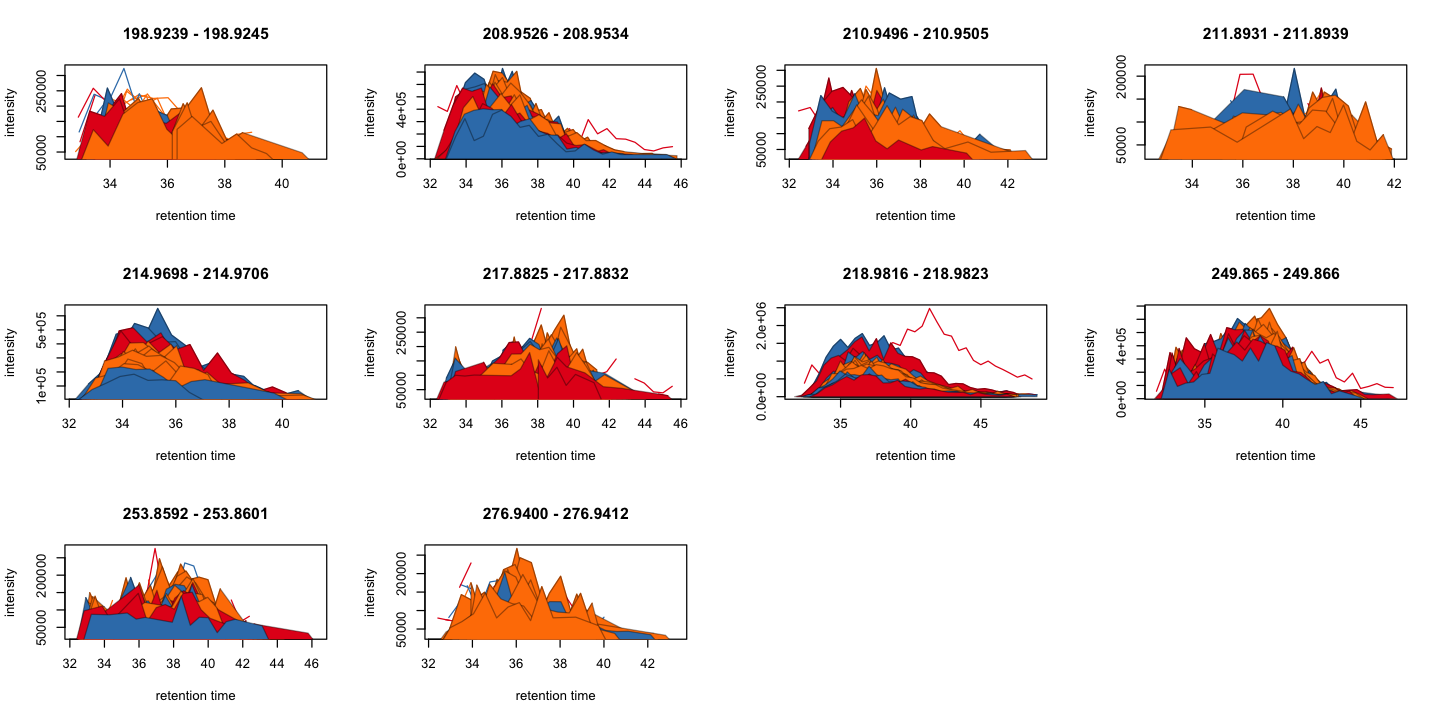

In [58]:
## Extract feature chromatograms
feature_chroms <- featureChromatograms(set, features = rowData(results)$label %in% 
                                       summary$label[1:10])

## Plot feature chromatograms
plot(feature_chroms, col = sample.colours,
     peakBg = sample.colours[chromPeaks(feature_chroms)[, "sample"]])

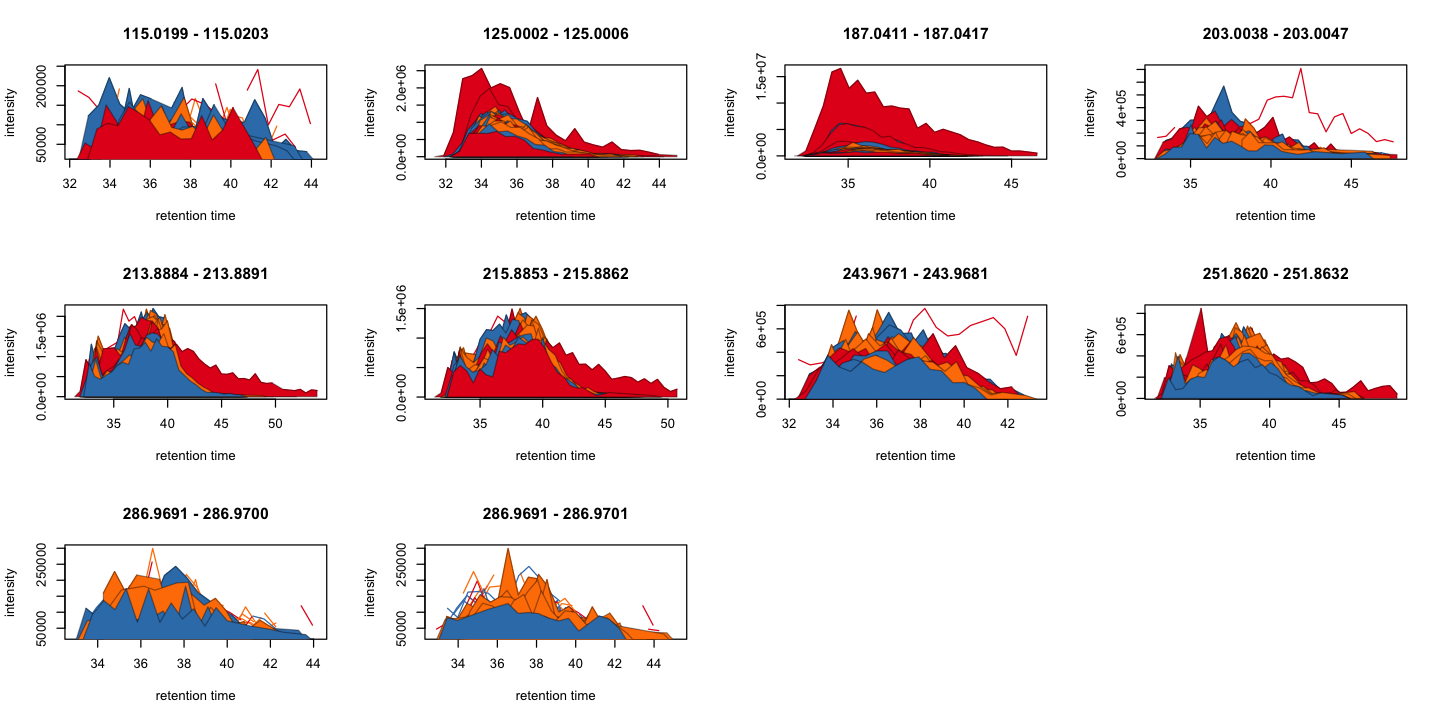

In [59]:
## Extract feature chromatograms
feature_chroms <- featureChromatograms(set, features = rowData(results)$label %in% 
                                       summary$label[11:20])

## Plot feature chromatograms
plot(feature_chroms, col = sample.colours,
     peakBg = sample.colours[chromPeaks(feature_chroms)[, "sample"]])

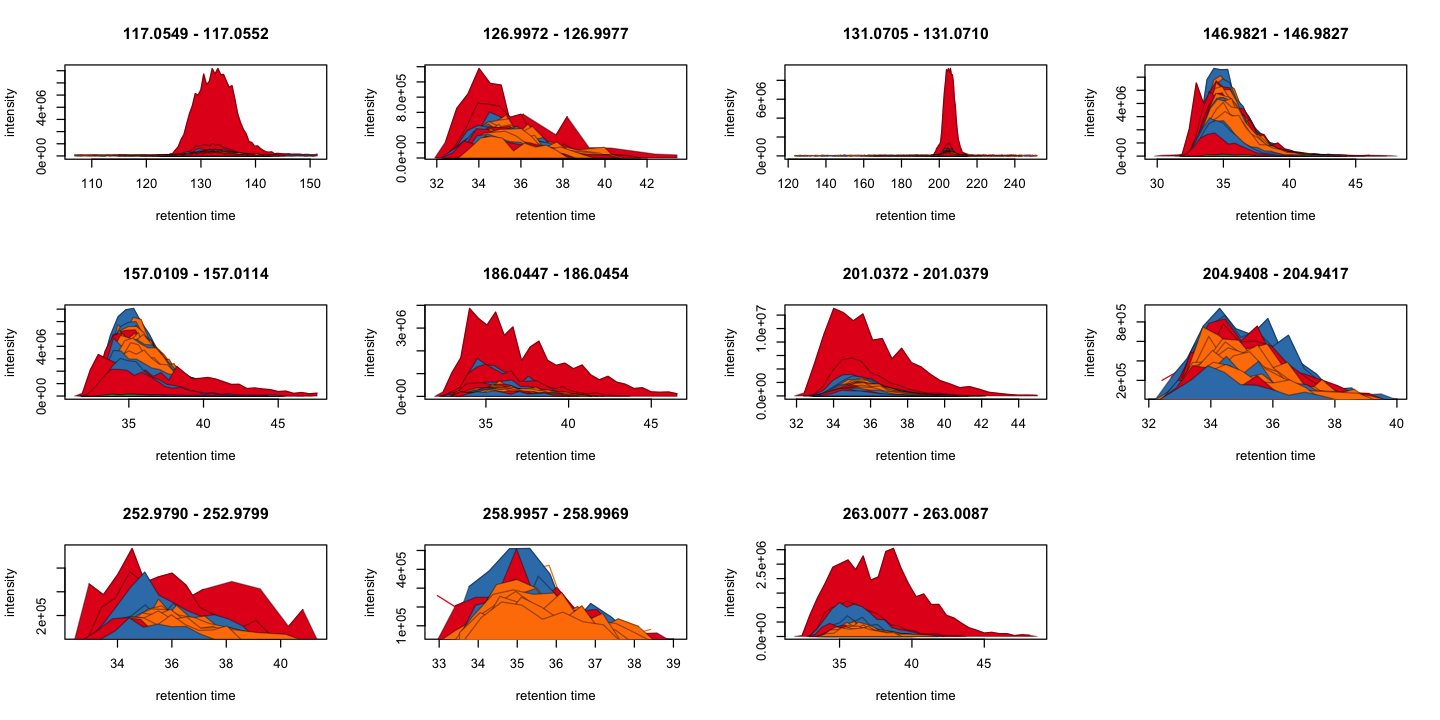

In [60]:
## Extract feature chromatograms
feature_chroms <- featureChromatograms(set, features = rowData(results)$label %in% 
                                       summary$label[21:31])

## Plot feature chromatograms
plot(feature_chroms, col = sample.colours,
     peakBg = sample.colours[chromPeaks(feature_chroms)[, "sample"]])

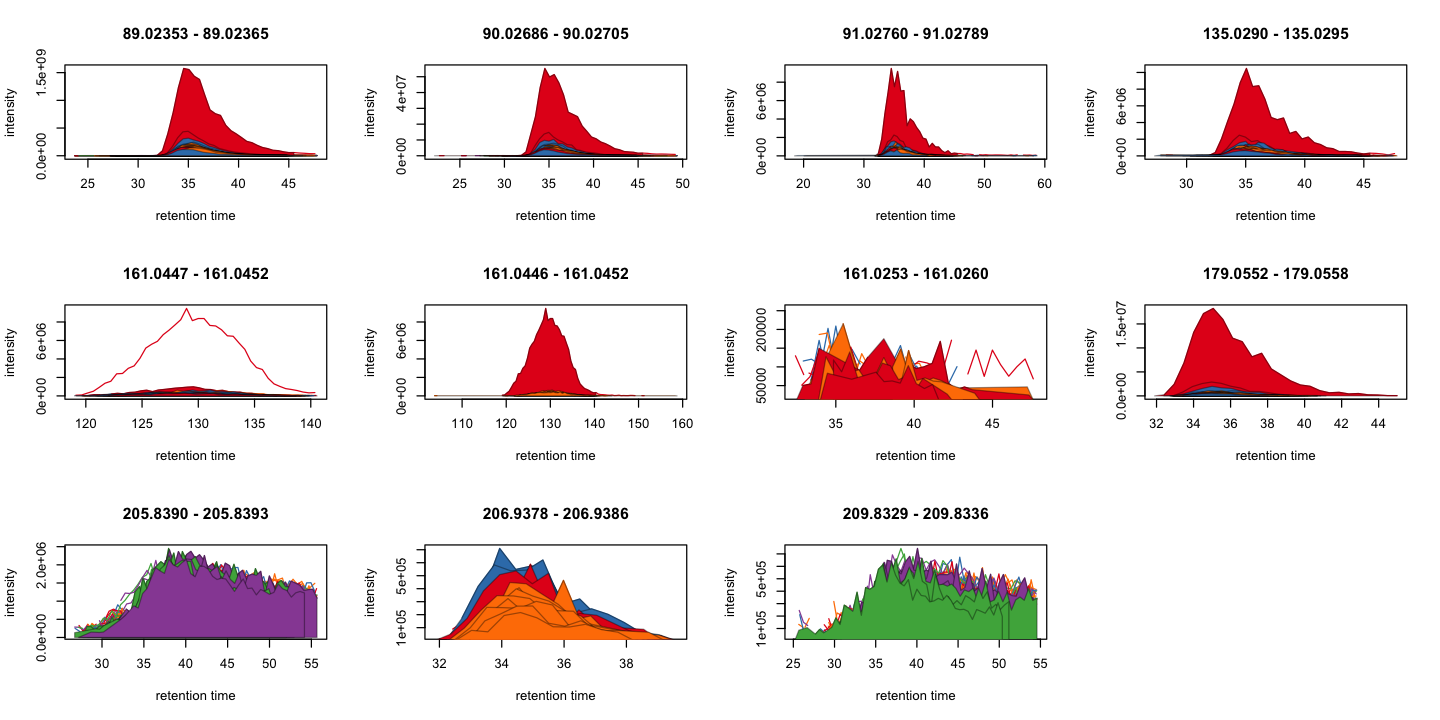

In [61]:
## Extract feature chromatograms
feature_chroms <- featureChromatograms(set, features = rowData(results)$label %in% 
                                       summary$label[32:42])

## Plot feature chromatograms
plot(feature_chroms, col = sample.colours,
     peakBg = sample.colours[chromPeaks(feature_chroms)[, "sample"]])

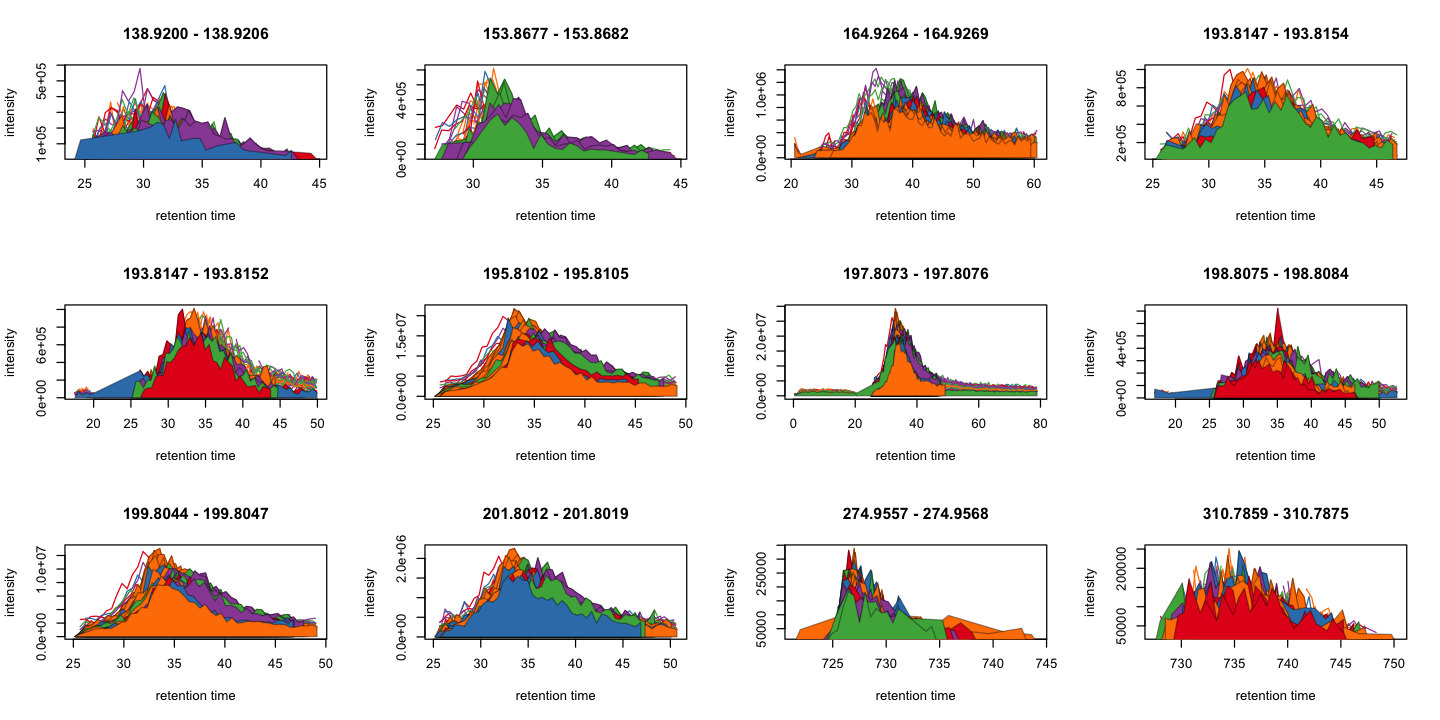

In [62]:
## Extract feature chromatograms
feature_chroms <- featureChromatograms(set, features = rowData(results)$label %in% 
                                       summary$label[43:54])

## Plot feature chromatograms
plot(feature_chroms, col = sample.colours,
     peakBg = sample.colours[chromPeaks(feature_chroms)[, "sample"]])

## Export inclusion list for identification via additional measurements

In [63]:
inclusion.list <- matrix(ncol = 12, nrow = 54, byrow = TRUE, 
                         dimnames = list(NULL, c("Mass [m/z]","Formula [M]",
                                           "Formula type","Species","CS [z]",
                                           "Polarity","Start [min]","End [min]",
                                           "(N)CE","(N)CE type","MSX ID","Comment")))

inclusion.list[,1] <- round(summary$mzmed[1:54],4)
inclusion.list[,6] <- rep("neg", 54)
inclusion.list[,7] <- round((summary$rtmed[1:54] - 30) / 60,2)
inclusion.list[,8] <- round((summary$rtmed[1:54] + 30) / 60,2)
inclusion.list[,12] <- summary$label[1:54]

write.csv(inclusion.list, "inclusion_list_PH_neg.csv", row.names = FALSE, quote = FALSE)

## Export data set for additional evaluations

In [64]:
write_xlsx(list(areas = as.data.frame(assay(results, "raw")), 
                peakdata = as.data.frame(rowData(results)), 
                filedata = as.data.frame(colData(results))), 
           "Enamel_PH_Neg.xlsx")

## Save dataset

In [65]:
save.image("Enamel_PH_neg.RData")

# Appendix

In [66]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRlapack.dylib

locale:
[1] de_DE.UTF-8/de_DE.UTF-8/de_DE.UTF-8/C/de_DE.UTF-8/de_DE.UTF-8

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggpubr_0.6.0                devtools_2.4.5             
 [3] usethis_3.1.0               writexl_1.5.1              
 [5] ggrepel_0.9.6               MASS_7.3-60                
 [7] caret_7.0-1                 lattice_0.22-6             
 [9] Rtsne_0.17                  gplots_3.2.0               
[11] lubridate_1.9.4             forcats_1.0.0              
[13] stringr_1.5.1               dplyr_1.1.4                
[15] purrr_1.0.2                 readr_2.1.5          